In [2]:
#import relevant packages
# from newspaper import Article
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import glob
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
import unicodedata
from datetime import timedelta,date
import json
import extract_keywords
# from corextopic import corextopic as ct
from fuzzywuzzy import fuzz
import imblearn
# import spacy
# from spacy import displacy
# from collections import Counter
# import en_core_web_sm
# nlp = en_core_web_sm.load()

/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS
from gensim.models.coherencemodel import CoherenceModel
# spacy for lemmatization
import spacy
nlp = spacy.load("en_core_web_sm")

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


### to come up with list of stopwords or remove certain categories of words
- adverbs (Adverbs of manner tell us how something happens. They are usually placed either after the main verb or after the object. Eg. he swims *well*)
- prepositions (Prepositions indicate relationships between other words in a sentence. Eg. Despite, after, contrary, as a result)
- verbs (A verb expresses a physical action Eg. created,tested,tried)

To do:
-Remove date, time, 

In [4]:
# stopwords
stop_words = stopwords
extra_stopwords = ['register','free','unlimited','reuters','com','report','shares', 'using','going','person', 'useful', 'govtech', 'cio', 'yonhap', 'size', 'tackle', 'right', 'day', 'tried', 'tested', 'make', 'sure', 'used', 'help', 'yesterday', 'today', 'tomorrow', 'percent', 'per', 'cent', 'could', 'many', 'add', 'use', 'need', 'goods', 'million', 'thousand', 'company', 'retailers', 'saw', 'see', 'new', 'like', 'today', 'tomorrow', 'guide',
                   'people', 'want', 'yet', 'way', 'time', 'back', 'whether', 'if', 'yes', 'older', 'noted', 'went', 'told', 'tell', 'younger', 'another', 'worth', 'noting', 'well', 'called', 'named', 'never', 'lee', 'quah', 'ong', 'ng', 'lim', 'tan', 'shared', 'says', 'say', 'said', 'cio', 'cios', 'month', 'top', 'world', 'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'january', 'february', 'march', 'april', 'may', 'june', 'july',
                   'august', 'september', 'october', 'november', 'december', 'month', 'months', 'years', 'year', 'near', 'also', 'would', 'able']
for word in extra_stopwords:
    stop_words.add(word)

In [ ]:
#import data
path2 ='/Users/ruinahkoh/dev/govtech/webscrapping/scrapeinfoworld/articles'
filenames = glob.glob(path2 + "/*.csv")

dfs = []
for filename in filenames:
    print(filename)
    df = pd.read_csv(filename)
    df['source'] =re.search('\/([A-Za-z]+)[0-9]?\.csv',filename)[1]
    dfs.append(df)

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True)
big_frame.head()

In [ ]:
with open(path2+ '/articles.json') as json_file:
    data = json.load(json_file)
df2= pd.DataFrame.from_records(data)

In [ ]:
dfs = [big_frame, df2]
big_frame = pd.concat(dfs, ignore_index=True)

In [ ]:
big_frame.head()

In [ ]:
words = [{'ai':1,'5g':1,'ml':1},{'ml':1},{'iot':1}]
dic0 = {}
dic2 ={}
for d in words:
    dic2 = dict(dic0, **d)
    dic0 =dic2
dic2.keys()

In [ ]:
# read in keywords json to extract only keywords
filename = '../Data/data_dictionary.json'

with open(filename) as f:
    keywords = json.load(f)
       

dic0 = {}
dic2 ={}
for k, v in keywords.items():
    dic1 = v
    dic2 = dict(dic0, **dic1)
    dic0 =dic2
keywords = set([x.lower().replace(' ', '_') for x in dic2.keys()])

In [ ]:
dic2.get('5g')

In [ ]:
keywords_org =set(lemmatization([keywords])[0])

In [ ]:
lemmat

In [ ]:

def remove_dict(v):
    '''
    takes in an object and transforms it to the correct format
    '''
   
    if type(v) == dict:
        v= v.get('S')
    elif type(v)==str:
        return v.lower()
    elif v is not None and type(v) !=float and 'M' in v:
        v= v.get('M').get('S').get('S').lower()
    else:
        v= np.nan
    return  v

In [ ]:
big_frame['category'] = big_frame['category'].apply(lambda x: remove_dict(x))
big_frame['date']= big_frame['date'].apply(lambda x: remove_dict(x))

In [ ]:
mapping = {'security':'cybersecurity', 
 'cyber-resilience':'cybersecurity',
 'fsi-fintech':'fintech',
'fsi/fintech':'fintech',
 'healthcare':'health',
 'inclusive-gov':'digital-government',
 'connected-gov':'digital-government',
    'smart-gov':'digital-government',
 'intelligent-gov':'digital-government', 
 'digital-gov':'digital-government',
'cloud-computing':'cloud',
'augmented-intelligence':'ai',
'artificial-intelligence':'ai',
'gov-experience': 'digital-government',
          'open-data':'data',
          'biz':'business'}

In [ ]:
mapping.keys()

### Shortening words to their shortform for standardization
- Allows the program to pick up artificial intelligence and ai as the same thing

In [ ]:
#acronyms
acronyms = {'artificial intelligence':'ai', 'internet of things':'internet', 'applications':'apps'}

In [11]:
category_map = {
    "analytics/ai/ml":['analytics','augmented-intelligence','machine-learning', 'business-intelligence','autonomous-cars', 'data','ai','insights','deepmind','big-data'],
    "digital-transformation":['digital-government','innovation','fintech', 'education','digital-economy','automation','cashless-payments', 'chip',
       'digital-banking','transformation','agtech','urban-tech','healthtech','smart-cities','e-commerce','smart-city', 'future-of-work','supply-chain','logistics', 'battery','electric-vehicles','electric-vehicle','critical-event-management','citizen-centric','digital-art'],
    "blockchain":['cryptocurrencies','cashless-payment','health', 'digital-art','blockchain','crypto','digital-currency','bitcoin'],
    "cybersecurity":['cyber','resilience','cybersecurity','hacking','cybercrime','politics','us-politics','cyber-futures'],
    "iot":['mobility','iot','5g','networks'],
    "apps/development/platforms":['apps','edge-computing','software-development','software','development-tools','platforms','collaboration-tools','cloud-computing','cloud'],
             "business"  :['business','social-media','ads','bytedance','california','nyregion','apple','facebook','chrome','google','asean','alibaba-cloud','huawei','startups','financial-conduct-authority']
}

In [12]:
keywords =[]
for v in category_map.values():
    keywords.extend(v)

In [14]:
keywords = [k.replace('-',' ') for k in keywords]

In [ ]:
category_map2={}
for k,v in category_map.items():
    for cat in v:
        category_map2[cat] = k

In [6]:
data= pd.read_csv('/Users/ruinah/Downloads/project/article_data.csv', index_col=0)
data2= pd.read_csv('/Users/ruinah/Downloads/project/article_data2.csv', index_col=0)
data3= pd.read_csv('/Users/ruinah/Downloads/project/article_data3.csv', index_col=0)
test_set= pd.read_csv('/Users/ruinah/Downloads/project/test_set.csv', index_col=0)
dataframe = pd.concat([data,data2,data3])

In [8]:
dataframe.dropna()

,title,imgurl,date,blurp,url,text,category,source
1,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,artificial intelligence,entrepreneur
2,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,artificial intelligence,the verge
3,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,artificial intelligence,reuters
4,7 Artificial Intelligence Stocks Under $10 for...,https://images.readwrite.com/wp-content/upload...,29/03/2022,"In recent years, artificial intelligence has b...",https://investorplace.com/2022/03/7-ai-stocks-...,7 Artificial Intelligence Stocks Under $10 for...,artificial intelligence,investorplace.com
5,Does AI get more hype than it deserves?,https://img-cdn.tnwcdn.com/image/neural?filter...,28/03/2022,How different would we think about artificial ...,https://thenextweb.com/news/ai-get-more-hype-t...,How different would we think about artificial ...,artificial intelligence,the next web
...,...,...,...,...,...,...,...,...
475,Investigating the drivers of remittance fees,https://voxeu.org/sites/default/files/cover_im...,18/04/2022,Remittances continue to be an importance sourc...,https://voxeu.org/article/investigating-driver...,Investigating the drivers of remittance fees\n...,digitalisation,voxeu.org
476,2C2P and Ant Group Enter Strategic Partnership...,https://mms.businesswire.com/media/20220418005...,18/04/2022,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",https://www.businesswire.com/news/home/2022041...,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",digitalisation,business wire
477,Real estate expert advises firms on building t...,https://cdn.punchng.com/wp-content/uploads/201...,18/04/2022,An expert in real estate development and busin...,https://punchng.com/real-estate-expert-advises...,An expert in real estate development and busin...,digitalisation,the punch
478,GobiMin reports its 2021 Financial Results,https://s.yimg.com/uu/api/res/1.2/cPoGCIMZcIVJ...,21/04/2022,(Expressed in United States dollars except whe...,https://finance.yahoo.com/news/gobimin-reports...,GobiMin Inc.\n\n(Expressed in United States do...,digitalisation,yahoo entertainment


In [2301]:
dataframe['source'].unique()

array(['wired', 'entrepreneur', 'the verge', 'reuters',
       'investorplace.com', 'the next web', 'venturebeat', 'arxiv.org',
       'the guardian', 'readwrite', 'ars technica', 'business insider',
       'nature.com', 'android central', 'new scientist', 'cnet',
       'the new yorker', 'scientific american', 'yanko design',
       'science daily', 'guelphtoday', 'cambridgetoday.ca',
       'the business of fashion', 'jhu.edu', 'theregister.com',
       'petapixel', 'hackaday', 'calendar.com', 'motley fool',
       'lifehacker.com', 'new york times', 'flower.dev', 'gizmodo.com',
       'slashdot.org', 'search engine land', 'blog.google',
       'toprankblog.com', 'search engine journal', 'fast company',
       'appleinsider', 'moz.com', 'engadget', 'stocknews.com',
       'marketbeat', 'vice news', 'internet', 'boing boing',
       'digital trends', 'github.com', 'android police', 'macrumors',
       '9to5mac', 'julialang.org', 'xda developers', 'googleblog.com',
       'ted.com', 'h

In [1502]:
cat_mapping = {'artificial intelligence':'ai', 'digital transformation':'digitalisation','iot':'digitalisation','cloud computing':'cloud', 'machine learning':'ai'}

In [1503]:
dataframe.category.unique()

array(['artificial intelligence', 'analytics', 'cybersecurity',
       'machine learning', 'blockchain', 'digital transformation', 'iot',
       'cloud computing', 'EV', 'digitalisation'], dtype=object)

## processing the dataset
- standardization of categories
- formating of date
- cleaning dirty data (headers are attached to csv, nan in text etc.)
- removal of articles with less than 50 words


In [1504]:
len(dataframe)

1600

In [5]:
def map_to_category(cat):
    '''
    standardization of categories by passing a dictionary mapping through the category field
    '''
    for key in cat_mapping.keys():
        if key == cat:
            cat= cat_mapping[cat.lower()]
        
    return cat

def count_words(text):
    return len(text)


#cleaning function to get list of cleaned words
def thorough_cleaning(text):
    text = ''.join(text)
    text = text.strip().lower()
    text = " ".join(text.split())
    text = re.sub("[^0-9a-zA-Z]"," ", text)
    text = re.sub('[0-9]{2,4}', ' ', text)
#     for pattern in acronyms:
#         text = re.sub(pattern,acronyms.get(pattern), text)
    article_text = re.sub(r'\s+', ' ', text)
    article_text = ' '.join([w.lower() for w in article_text.split() if len(w) > 1 and w not in stop_words])
    article_text = unicodedata.normalize("NFKD", article_text)
    return article_text.lower().split()

def process_data(df):
    #remove duplicates and nan
    df.drop_duplicates(subset =['title','category'], inplace=True)
    df.dropna(axis =0, subset =['text', 'title'], inplace=True)
    #mapping to standardize categories
    df = df[df['category']!='analytics']
    df['category'] = df['category'].apply(lambda x: map_to_category(x))
   
    #cleaning the text to convert to lists
    df['clean_text'] = df['text'].apply(lambda x:thorough_cleaning(x))
    
    df['keywords']=df['text'].apply(lambda x: extract_keywords.extract_single_text_ngram(x,keywords ))
    #word count of text
    df['word_count'] = df['clean_text'].apply(lambda x: len(x))
    #remove those which are too short
    df2 = df[df.word_count >=100]
    return df2.reset_index(drop=True)




## Using Gensim Topic Modelling to extract keywords by topic

Gensim topic modelling can output topics as well as the list of keywords, thus it might be useful in identifying keywords

In [2332]:
dataframe.category.unique()

array(['artificial intelligence', 'analytics', 'cybersecurity',
       'machine learning', 'blockchain', 'digital transformation', 'iot',
       'cloud computing', 'EV', 'digitalisation'], dtype=object)

In [2333]:
df = process_data(dataframe)
len(df)

/var/folders/h5/q_hpffn12_589xblfw6_4j1m0000gn/T/ipykernel_24615/3647579332.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['category'] = df['category'].apply(lambda x: map_to_category(x))
/var/folders/h5/q_hpffn12_589xblfw6_4j1m0000gn/T/ipykernel_24615/3647579332.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].apply(lambda x:thorough_cleaning(x))
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureW

521

In [2457]:
test_set_cleaned = process_data(test_set)

/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [2458]:
len(test_set_cleaned)

71

In [2460]:
cat_test = test_set_cleaned[['title','category']].groupby(['title']).agg({'category': lambda x: x.tolist()})
test_set_cleaned = test_set_cleaned.merge(cat_test, on='title').drop(columns = ['category_x'])

In [2462]:
test_set_cleaned

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y
0,Open source technology in logistics sector,https://ubuntu.com/wp-content/uploads/dc7e/sha...,27/04/2022,Why use open source technology in industries? ...,https://ubuntu.com/blog/open-source-technology...,Why use open source technology in industries?\...,ubuntu.com,"[open, source, industries, word, open, source,...","digital transformation, logistics sector, mult...",740,[digitalisation]
1,Five new partners of PKF hospitality group,https://www.hospitalitynet.org/HN-icon.jpg,27/04/2022,PKF hospitality group announces five new partn...,https://www.hospitalitynet.org/news/4110164.html,PKF hospitality group announces five new partn...,hospitality net,"[pkf, hospitality, group, announces, partners,...","tourism leisure, research, leisure, tourism, h...",216,[digitalisation]
2,A hostile parliament to Macron could paralyse ...,https://www.euractiv.com/wp-content/uploads/si...,27/04/2022,"In today’s edition of the Capitals, find out m...",https://www.euractiv.com/section/politics/news...,The Capitals brings you the latest news from a...,euractiv,"[capitals, brings, latest, news, across, europ...","read, european, president, european commission...",1152,[digitalisation]
3,Bink appoints executives from HSBC and Visa as...,https://www.finextra.com/finextra-images/top_p...,27/04/2022,Loyalty app Bink has appointed two executives ...,https://www.finextra.com/newsarticle/40143/bin...,Loyalty app Bink has appointed two executives ...,finextra,"[loyalty, app, bink, appointed, executives, hs...","business, lloyds, bink, loyalty, hsbc, asia pa...",192,[digitalisation]
4,Africa: Tough Reforms Needed to Support Africa...,https://cdn08.allafrica.com/static/images/stru...,27/04/2022,[Ghanaian Times] Tough reforms anchored on eff...,https://allafrica.com/stories/202204270399.html,Tough reforms anchored on effective revenue mo...,allafrica - top africa news,"[tough, reforms, anchored, effective, revenue,...","business, pandemic, sector, economic, financia...",323,[digitalisation]
...,...,...,...,...,...,...,...,...,...,...,...
66,Should You Buy Tesla Ahead of Its Stock Split?,https://g.foolcdn.com/editorial/images/673559/...,27/04/2022,The EV leader is gearing up for another stock ...,https://www.fool.com/investing/2022/04/27/shou...,A regulatory filing made by Tesla (TSLA 2.94%)...,motley fool,"[regulatory, filing, made, tesla, tsla, end, r...","stock, investors, market, margin, impressive g...",307,[EV]
67,Lucid signs deal with Saudi Arabia for up to 1...,https://o.aolcdn.com/images/dims3/GLOB/legacy_...,27/04/2022,"Filed under:\n Green,Electric,Lucid\n Continue...",https://www.autoblog.com/2022/04/27/lucid-1000...,Electric carmaker Lucid Group on Tuesday said ...,autoblog,"[electric, carmaker, lucid, group, tuesday, si...","vehicles, production, agreement, saudi arabia,...",139,[EV]
68,Batteries are getting cheap. So why aren’t ele...,https://grist.org/wp-content/uploads/2022/04/t...,27/04/2022,"In 2015, the average price paid for an EV was ...",http://grist.org/article/batteries-are-getting...,If the world has learned one thing from the ad...,grist,"[learned, thing, adoption, wind, solar, green,...","powered cars, electric car, price parity, car,...",692,[EV]
69,LIC valuation may be among cheapest for global...,"https://img.etimg.com/thumb/msid-91112826,widt...",27/04/2022,"According to Sunil Tirumalai, strategist at UB...",https://economictimes.indiatimes.com/markets/i...,Agencies\n\nMumbai: Life Insurance of Corporat...,the times of india,"[agencies, mumbai, life, insurance, corporatio...","price, market, crore, ipo lic, grey market, ip...",171,[EV]


In [2334]:
df.head()

,title,imgurl,date,blurp,url,text,category,source,clean_text,keywords,word_count
0,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,ai,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",283
1,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,ai,the verge,"[artificial, intelligence, tool, reads, chest,...","oxipit statement, x, ce mark, x rays, programs...",211
2,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,ai,reuters,"[football, clubs, australia, artificial, intel...","gobubble, safe, technology, unlimited access, ...",122
3,Does AI get more hype than it deserves?,https://img-cdn.tnwcdn.com/image/neural?filter...,28/03/2022,How different would we think about artificial ...,https://thenextweb.com/news/ai-get-more-hype-t...,How different would we think about artificial ...,ai,the next web,"[different, think, artificial, intelligence, a...","thought experiment, complex, artificial, artif...",503
4,China uses AI software to improve its surveill...,https://www.reuters.com/resizer/xUweqB0rmCsdEw...,08/04/2022,Dozens of Chinese firms have built software th...,https://www.reuters.com/world/china/china-uses...,"BEIJING, April 8 (Reuters) - Dozens of Chinese...",ai,reuters,"[beijing, dozens, chinese, firms, built, softw...","software, security, tenders, huawei, comment, ...",726


In [2335]:
category_merged = df[['title','category']].groupby(['title']).agg({'category': lambda x: x.tolist()})
category_merged

,category
title,
16th MiningForum in Berlin shows new and sustainable perspectives on the mineral resources sector,[digitalisation]
2 Monster Growth Stocks to Buy Now and Hold Until You Retire,[digitalisation]
2 Unstoppable Growth Stocks to Buy Now and Hold,[cloud]
2 surprising uses of blockchain that could change the world,[blockchain]
2C2P and Ant Group Enter Strategic Partnership to Further Digital Payment Adoption and Innovation in Southeast Asia Amid Regional Economic Recovery,[digitalisation]
...,...
Your Coding Journey Starts with Python,[ai]
Your digital footprints could help hackers infiltrate computer networks,[cybersecurity]
Youths happy to put ecash aid to good use,[digitalisation]


In [2336]:
df = df.merge(category_merged, on='title').drop(columns = ['category_x'])

In [2337]:
df

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y
0,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",283,"[ai, ai]"
1,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",283,"[ai, ai]"
2,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,the verge,"[artificial, intelligence, tool, reads, chest,...","oxipit statement, x, ce mark, x rays, programs...",211,[ai]
3,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[football, clubs, australia, artificial, intel...","gobubble, safe, technology, unlimited access, ...",122,"[ai, ai]"
4,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[football, clubs, australia, artificial, intel...","gobubble, safe, technology, unlimited access, ...",122,"[ai, ai]"
...,...,...,...,...,...,...,...,...,...,...,...
516,Investigating the drivers of remittance fees,https://voxeu.org/sites/default/files/cover_im...,18/04/2022,Remittances continue to be an importance sourc...,https://voxeu.org/article/investigating-driver...,Investigating the drivers of remittance fees\n...,voxeu.org,"[investigating, drivers, remittance, fees, tho...","higher, market, remittance fees, corridors, fe...",768,[digitalisation]
517,2C2P and Ant Group Enter Strategic Partnership...,https://mms.businesswire.com/media/20220418005...,18/04/2022,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",https://www.businesswire.com/news/home/2022041...,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",business wire,"[singapore, business, wire, 2c2p, global, paym...","ant, business, partnership, payments solutions...",423,[digitalisation]
518,Real estate expert advises firms on building t...,https://cdn.punchng.com/wp-content/uploads/201...,18/04/2022,An expert in real estate development and busin...,https://punchng.com/real-estate-expert-advises...,An expert in real estate development and busin...,the punch,"[expert, real, estate, development, business, ...","others, society, whole part, real, businesses,...",234,[digitalisation]
519,GobiMin reports its 2021 Financial Results,https://s.yimg.com/uu/api/res/1.2/cPoGCIMZcIVJ...,21/04/2022,(Expressed in United States dollars except whe...,https://finance.yahoo.com/news/gobimin-reports...,GobiMin Inc.\n\n(Expressed in United States do...,yahoo entertainment,"[gobimin, inc, expressed, united, states, doll...","properties, financial, loss, gobimin, value, i...",603,[digitalisation]


In [2338]:
df.drop_duplicates(subset = ['title'], inplace =True)
len(df)

480

In [2339]:
df.category_y.value_counts()

[digitalisation]                           142
[ai]                                        86
[EV]                                        63
[cybersecurity]                             55
[blockchain]                                51
[cloud]                                     47
[ai, ai]                                     7
[cybersecurity, digitalisation]              6
[digitalisation, cloud]                      4
[ai, cloud]                                  3
[digitalisation, digitalisation]             3
[cybersecurity, blockchain]                  3
[ai, digitalisation]                         2
[ai, blockchain, digitalisation]             1
[cybersecurity, cloud]                       1
[ai, blockchain]                             1
[ai, ai, cloud]                              1
[blockchain, digitalisation]                 1
[blockchain, digitalisation, cloud]          1
[digitalisation, digitalisation, cloud]      1
[ai, digitalisation, cloud]                  1
Name: categor

In [1514]:
df.reset_index(drop=True, inplace=True)
len(df)

489

In [1516]:
data_ro = df[df['category_y'].isin([['digitalisation'], ['ai'],['blockchain'],['EV'],['cloud'],['cybersecurity']])]
data_remaining = df[~df['category_y'].isin([['digitalisation'], ['ai'],['blockchain'],['EV'],['cloud'],['cybersecurity']])]
data_ro['category_y'].apply(lambda x: x[0])

1                  ai
3                  ai
4                  ai
5                  ai
6                  ai
            ...      
484    digitalisation
485    digitalisation
486    digitalisation
487    digitalisation
488    digitalisation
Name: category_y, Length: 453, dtype: object

In [1735]:
import imblearn
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
undersample = RandomUnderSampler(random_state =42)
oversample = RandomOverSampler(random_state =42)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(data_ro[['clean_text','text','date']], data_ro['category_y'].apply(lambda x: x[0]))


In [1137]:
data_remaining['category_y']

9              [ai, digitalisation, cloud]
17                             [ai, cloud]
23                             [ai, cloud]
30                             [ai, cloud]
39                        [ai, blockchain]
40        [ai, blockchain, digitalisation]
43                             [ai, cloud]
60         [cybersecurity, digitalisation]
63                  [cybersecurity, cloud]
72         [cybersecurity, digitalisation]
73         [cybersecurity, digitalisation]
77         [cybersecurity, digitalisation]
80         [cybersecurity, digitalisation]
92             [cybersecurity, blockchain]
93             [cybersecurity, blockchain]
94         [cybersecurity, digitalisation]
108                   [ai, digitalisation]
154           [blockchain, digitalisation]
155    [blockchain, digitalisation, cloud]
217                [digitalisation, cloud]
221                [digitalisation, cloud]
224                [digitalisation, cloud]
234                [digitalisation, cloud]
237        

In [1519]:
y_over.value_counts()

EV                47
ai                47
blockchain        47
cloud             47
cybersecurity     47
digitalisation    47
Name: category_y, dtype: int64

In [1520]:
data_ro['category_y'].apply(lambda x: x[0]).value_counts()

digitalisation    145
ai                 88
EV                 65
cybersecurity      56
blockchain         52
cloud              47
Name: category_y, dtype: int64

In [1521]:
test = pd.DataFrame()

In [1522]:
test['y']= pd.concat([y_over,data_remaining['category_y']] ).reset_index(drop=True)

In [1523]:
test['tokens']= pd.concat([X_over['clean_text'],data_remaining['clean_text']]).reset_index(drop=True)

In [1524]:
test['text'] = pd.concat([X_over['text'],data_remaining['text']]).reset_index(drop=True)



In [1736]:
test['date'] = pd.concat([X_over['date'],data_remaining['date']]).reset_index(drop=True)

In [1525]:
def has_d(text):
    if 'technology' in text:
        return 1
    else:
        return 0

In [1526]:
len(test)

318

In [1527]:
# data['new_cat']= data.category.map(category_map2)
# data.groupby('new_cat').size()
# df.new_cat.fillna('other').groupby().size()


In [1528]:
test[test.y=='digitalisation']

,y,tokens,text
235,digitalisation,"[norwind, offshore, signs, flexible, connectiv...",Norwind Offshore signs flexible connectivity a...
236,digitalisation,"[batmobile, batman, movie, looks, stunning, ra...","Yes, the Batmobile in The Batman movie looks s..."
237,digitalisation,"[private, security, guard, stands, exit, gate,...",A private security guard stands at the exit ga...
238,digitalisation,"[windows, pointed, last, week, still, rules, m...",Windows 10 – as we pointed out last week – sti...
239,digitalisation,"[products, recommended, engadget, selected, ed...",All products recommended by Engadget are selec...
240,digitalisation,"[transport, group, go, ahead, pledged, resume,...",Transport group Go-Ahead has pledged to resume...
241,digitalisation,"[intel, study, finds, businesses, eager, cyber...",An Intel study finds that businesses are eager...
242,digitalisation,"[george, town, cope, increase, minimum, wage, ...",GEORGE TOWN: To cope with the increase in the ...
243,digitalisation,"[tim, logo, seen, headquarters, rome, italy, y...",The Tim logo is seen at its headquarters in Ro...
244,digitalisation,"[chairs, spokespersons, working, groups, table...",The Chairs and spokespersons of nine Working G...


In [1148]:
X

0      [opinions, expressed, entrepreneur, contributo...
1      [artificial, intelligence, tool, reads, chest,...
2      [reuters, football, clubs, australia, artifici...
3      [different, think, artificial, intelligence, a...
4      [beijing, reuters, dozens, chinese, firms, bui...
                             ...                        
895    [gamesbeat, summit, returns, largest, event, l...
896    [big, data, analytics, cloud, computing, iot, ...
897    [although, ukraine, russia, war, worsened, glo...
898    [bank, england, asking, lenders, insurers, pay...
899    [north, korea, huge, crypto, hack, marks, era,...
Name: clean_text, Length: 900, dtype: object

### Processing the text into unigrams, bigrams and trigrams
- Breakdown into unigrams/bigrams/trigrams
- Lemmatize data
- Create word embeddings

### LDA Topic Modelling for keywords
- This section tries out topic modelling which attaches a list of keywords to topics

In [1530]:
### set a defined list of topics
topics = ['ai','analytics', 'electric_vehicles','cybersecurity', 'digitalisation','machine_learning', 'blockchain', 'digital_transformation','artificial_intelligence','digitalisation','iot','cloud computing','ev']

#function for making bigrams and trigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags or token.lemma_ in topics]) # prevent lemmatization from removing impt keywords
    return texts_out

In [2681]:
def prepare_data(cleaned_text):
    bigram = gensim.models.Phrases(cleaned_text, min_count=40, threshold=50) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[cleaned_text], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
#     print(trigram_mod[bigram_mod[text.loc[1]]])

    # Form Bigrams
    data_words_bigrams = make_bigrams(cleaned_text)
    data_words_trigrams = make_trigrams(cleaned_text)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # # python3 -m spacy download en
    # nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

#     print(data_lemmatized[:1])

    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus,data_words_bigrams, data_lemmatized,id2word

def prepare_data_test(cleaned_text, id2word):
    bigram = gensim.models.Phrases(cleaned_text, min_count=40, threshold=50) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[cleaned_text], threshold=50)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
#     print(trigram_mod[bigram_mod[text.loc[1]]])

    # Form Bigrams
    data_words_bigrams = make_bigrams(cleaned_text)
    data_words_trigrams = make_trigrams(cleaned_text)
    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # # python3 -m spacy download en
    # nlp = spacy.load('en', disable=['parser', 'ner'])

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])

#     print(data_lemmatized[:1])

    # Create Dictionary
#     id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return corpus,data_words_bigrams, data_lemmatized

In [2546]:
def build_lda(corpus, id2word,num_topics,chunksize=100, passes=1, per_word_topics=False):

    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=chunksize,
                                               passes=passes,
                                               alpha='auto',
                                               per_word_topics=per_word_topics)
    return lda_model

In [2448]:
lda_model, corpus, data_words_bigrams, data_lemmatized,id2word = build_lda(corpus, id2word, test['tokens'],6,chunksize = 70, passes = 10)

In [2449]:
lda_model[corpus[3]]

[(1, 0.38191405), (2, 0.39811808), (4, 0.02214792), (5, 0.1967698)]

### Defining topics first to prevent lemmatization from removing relevant keywords

In [2450]:
print(lda_model.print_topics()[0])

(0, '0.030*"game" + 0.025*"blockchain" + 0.010*"digital" + 0.010*"player" + 0.008*"fund" + 0.008*"firm" + 0.008*"security" + 0.007*"hacker" + 0.007*"cryptocurrency" + 0.007*"transaction"')


In [2515]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
# doc_lda = lda_model[corpus]

[(0, '0.030*"game" + 0.025*"blockchain" + 0.010*"digital" + 0.010*"player" + 0.008*"fund" + 0.008*"firm" + 0.008*"security" + 0.007*"hacker" + 0.007*"cryptocurrency" + 0.007*"transaction"'), (1, '0.010*"stock" + 0.010*"market" + 0.008*"group" + 0.007*"revenue" + 0.007*"service" + 0.007*"cybersecurity" + 0.007*"industry" + 0.007*"company" + 0.006*"government" + 0.006*"growth"'), (2, '0.012*"machine" + 0.011*"car" + 0.009*"ev" + 0.008*"vehicle" + 0.006*"space" + 0.005*"somnium" + 0.005*"model" + 0.005*"battery" + 0.004*"sale" + 0.004*"design"'), (3, '0.011*"attack" + 0.009*"nation" + 0.009*"export" + 0.008*"cyber" + 0.008*"nuclear" + 0.007*"policy" + 0.007*"exclusion" + 0.007*"war" + 0.007*"military" + 0.005*"redbord"'), (4, '0.028*"ai" + 0.015*"model" + 0.013*"system" + 0.010*"computer" + 0.009*"quantum" + 0.008*"code" + 0.008*"image" + 0.008*"human" + 0.006*"datum" + 0.006*"tool"'), (5, '0.027*"datum" + 0.018*"business" + 0.011*"cloud" + 0.011*"service" + 0.011*"security" + 0.009*"plat

In [2452]:
topic_dict={0:'blockchain/cybersecurity',1: 'market/cybersecurity/government',2:'EV',3:'war/cybersecurity/security',4:'data/machine_learning/ai',5:'data/cloud/digitalisation/cybersecurity'}
topic_dict

{0: 'blockchain/cybersecurity',
 1: 'market/cybersecurity/government',
 2: 'EV',
 3: 'war/cybersecurity/security',
 4: 'data/machine_learning/ai',
 5: 'data/cloud/digitalisation/cybersecurity'}

In [2453]:
percent = {5:33.7, 1:22,4:20.1,2:6.7,3:3.3, 0:14.1}

In [2454]:
for i in percent.keys():
    print("the percentage of tokens for", topic_dict[i],'is:' ,percent[i] )

the percentage of tokens for data/cloud/digitalisation/cybersecurity is: 33.7
the percentage of tokens for market/cybersecurity/government is: 22
the percentage of tokens for data/machine_learning/ai is: 20.1
the percentage of tokens for EV is: 6.7
the percentage of tokens for war/cybersecurity/security is: 3.3
the percentage of tokens for blockchain/cybersecurity is: 14.1


In [2455]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='mmds')
vis

/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's docum

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.148470  0.075505       1        1  33.741983
1     -0.054329 -0.230976       2        1  22.129879
4     -0.287541 -0.034710       3        1  20.086219
0      0.025527  0.264318       4        1  14.050559
2      0.203990 -0.154535       5        1   6.682835
3      0.260823  0.080398       6        1   3.308525, topic_info=            Term        Freq       Total Category  logprob  loglift
634         game  326.000000  326.000000  Default  30.0000  30.0000
2105          ai  505.000000  505.000000  Default  29.0000  29.0000
32         datum  776.000000  776.000000  Default  28.0000  28.0000
3584  blockchain  316.000000  316.000000  Default  27.0000  27.0000
797     business  542.000000  542.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
157       target   11.154313   75.518317   Topic6  -5.3988   1.4961
70    government   11.056795  130.833962   Topic6  -5.4076   0.9378
1999       trade    8.747856   46.089266   Topic6  -5.6418   1.7469
452        group    9.750790  224.722987   Topic6  -5.5333   0.2711
2129       email    7.780765   55.623448   Topic6  -5.7590   1.4417

[396 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
7960      6  0.881240  abusive
2014      1  0.296146  account
2014      3  0.325761  account
2014      5  0.384990  account
2379      3  0.985746    actor
...     ...       ...      ...
1634      2  0.050752   worker
4906      1  0.044640    world
4906      4  0.937430    world
6943      4  0.950100     wyze
5364      6  0.813352  zachxbt

[693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 1, 3, 4])

In [2447]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=6, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=70,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=False)
cm = CoherenceModel(model=lda_model, corpus=corpus, texts = data_lemmatized, coherence='c_v')
coherence = cm.get_coherence()
print('\nCoherence Score: ', coherence)



Coherence Score:  0.4616736511281971


In [2429]:
coherence_score = []
for i in range(2,15):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=65,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=False)
    cm = CoherenceModel(model=lda_model, corpus=corpus, texts =data_lemmatized, coherence='c_v')
    coherence = cm.get_coherence()
    print('Num topics:', i,'\nCoherence Score: ', coherence)
    coherence_score.append(coherence)


Num topics: 2 
Coherence Score:  0.3985385736867677
Num topics: 3 
Coherence Score:  0.3993191039481938
Num topics: 4 
Coherence Score:  0.40711962475660657
Num topics: 5 
Coherence Score:  0.4649242784091411
Num topics: 6 
Coherence Score:  0.4729365460321198
Num topics: 7 
Coherence Score:  0.4383669894143724
Num topics: 8 
Coherence Score:  0.49246231795174045
Num topics: 9 
Coherence Score:  0.47351132904326676
Num topics: 10 
Coherence Score:  0.45604527903396275
Num topics: 11 
Coherence Score:  0.45974701305843485
Num topics: 12 
Coherence Score:  0.3852290592411462
Num topics: 13 
Coherence Score:  0.43410832134852095
Num topics: 14 
Coherence Score:  0.439595667006933


Text(0, 0.5, 'c_v coherence score')

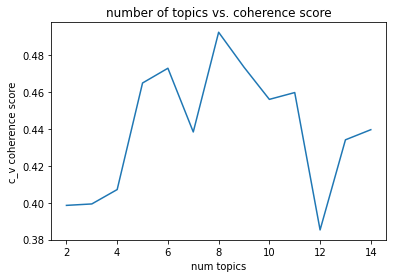

In [2430]:
plt.plot(list(range(2,15)),coherence_score )
plt.title("number of topics vs. coherence score")
plt.xlabel('num topics')
plt.ylabel('c_v coherence score')

In [2354]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, chunksize =70, passes=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [2355]:
coherence_values

[nan, nan, nan, nan, nan, nan, nan, nan]

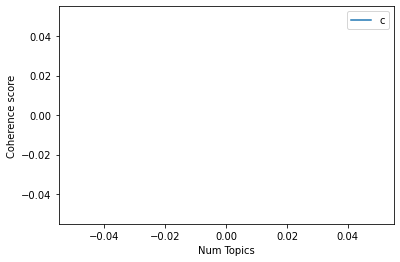

In [2353]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=test['tokens'], start=2, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [2239]:
labels = [lda_model.get_document_topics(doc,minimum_probability=0.1) for doc in corpus ]
test['labels'] =labels

In [2709]:
def assign_label(label,topic_dict):
    labelled=[]
    for l in label:
        labelled.append(topic_dict.get(l[0]))
    return labelled
def return_max(label,topic_dict):
    """
    takes a list of tuple(s)
    and returns the tuple with the highest second element
    """
    max_val= max(label, key=lambda x:x[1])[1]
    return [topic_dict.get(e[0]) for e in label if e[1] == max_val][0]
def check_category(labels, category):
    com=[]
    for l in labels:
        s = l.split('/')
        for i in s:
            com.append(i.lower())
#     print(com)
    if any(x.lower() in category for x in com):
        return 1
    else:
        return 0
def check_category2(labels, category):
    com=[]
    s = labels.split('/')


    if any(x in category for x in s):
        return 1
    else:
        return 0

In [2886]:
def get_labels(df, lda_model, corpus, topic_dict,  y_column='category_y',prob=0.2):
    labels = [lda_model.get_document_topics(doc,minimum_probability=prob) for doc in corpus ]
    df['labels'] =labels
    df['category'] = df[y_column].apply(lambda x: [i.lower() for i in x])
    df['predicted_labels'] = df.labels.apply(lambda x: assign_label(x, topic_dict))
    df['correct'] = df.apply(lambda x: check_category(x['predicted_labels'], x['category']), axis=1)
    print("the no of correct labels is:" , df['correct'].sum() / len(df['correct']))
    return df.reset_index(drop=True)

In [2707]:
test['predicted_labels'] = test.labels.apply(lambda x: assign_label(x, topic_dict))
test['predicted_labels2'] = test.labels.apply(lambda x: return_max(x, topic_dict))

In [2242]:
test['correct'] = test.apply(lambda x: check_category(x['predicted_labels'], x['y']), axis=1)
test['correct'].sum() / len(test['correct'])

0.8836477987421384

In [2243]:
line_chart = test[['date','predicted_labels']].explode(['predicted_labels']).reset_index(drop =True)

In [2244]:
line_chart

,date,predicted_labels
0,19/04/2022,market/cybersecurity/government
1,19/04/2022,EV
2,22/04/2022,market/cybersecurity/government
3,22/04/2022,data/cloud/digitalisation/cybersecurity
4,12/04/2022,EV
...,...,...
715,20/04/2022,market/cybersecurity/government
716,16/04/2022,blockchain/cybersecurity
717,16/04/2022,market/cybersecurity/government
718,16/04/2022,war/cybersecurity/security


In [2245]:
def mov_avg(x, w):
    for m in range(len(x)-(w-1)):
        yield sum(np.ones(w) * x[m:m+w])  /w

In [2832]:
def format_date(date):
    return datetime.datetime.strftime(date,'%d/%m')
def create_line_chart(df,topic_dict):
    line_chart = df[['date','predicted_labels']].explode(['predicted_labels']).reset_index(drop =True)
    line_chart['date'] = [datetime.datetime.strptime(ts, "%d/%m/%Y") for ts in line_chart['date']]
    line_chart = line_chart.groupby(['date','predicted_labels']).size().reset_index().rename(columns={0:'counts'})
    line_chart = line_chart.pivot(index='date', columns='predicted_labels', values='counts').fillna(0.0)
    line_chart = line_chart.reset_index().sort_values('date', ascending= True)
    plt.figure(figsize=(15, 9), dpi=80)
    for v in topic_dict.values():
    # for v in ['blockchain/cybersecurity', 'EV', 'government/cybersecurity/security']:

        plt.plot(line_chart.date[4:], list(mov_avg(line_chart[v],5)) ,label=str(v))
    plt.legend()
    plt.title('trend of topics (smoothed by 5 day MA)')
    plt.show()

In [2833]:
line_chart['date'] = [datetime.datetime.strptime(ts, "%d/%m/%Y") for ts in line_chart['date']]

TypeError: strptime() argument 1 must be str, not Timestamp

In [2249]:
line_chart = line_chart.groupby(['date','predicted_labels']).size().reset_index().rename(columns={0:'counts'})

In [2250]:
line_chart = line_chart.pivot(index='date', columns='predicted_labels', values='counts').fillna(0.0)

In [2251]:
line_chart = line_chart.reset_index().sort_values('date', ascending= True)

In [2252]:
def format_date(date):
    return datetime.datetime.strftime(date,'%d/%m')

In [2253]:
topic_dict.values()

dict_values(['blockchain/cybersecurity', 'market/cybersecurity/government', 'EV', 'war/cybersecurity/security', 'data/machine_learning/ai', 'data/cloud/digitalisation/cybersecurity'])

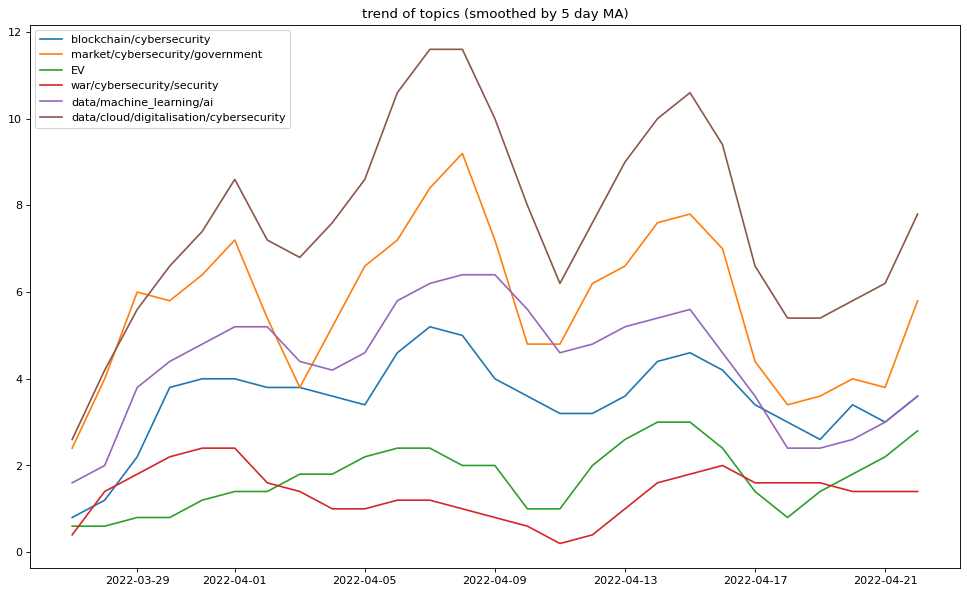

In [2254]:
plt.figure(figsize=(15, 9), dpi=80)
for v in topic_dict.values():
# for v in ['blockchain/cybersecurity', 'EV', 'government/cybersecurity/security']:

    plt.plot(line_chart.date[4:], list(mov_avg(line_chart[v],5)) ,label=str(v))
plt.legend()
plt.title('trend of topics (smoothed by 5 day MA)')
plt.show()

In [2100]:
line_chart.columns,


Index(['EV', 'blockchain/cybersecurity', 'data/cloud/digitalisation/security',
       'data/machine_learning/ai', 'government/cybersecurity/security',
       'market/digitalisation'],
      dtype='object', name='predicted_labels')

In [2484]:

lda_model.get_term_topics("digital", minimum_probability=0.000001)

[(0, 0.010234868), (1, 0.0015339621), (5, 0.007447765)]

In [2061]:
lda_model.get_term_topics("protection", minimum_probability=0.000001)

[(0, 0.00030903766), (1, 1.7006605e-05), (4, 0.00020232421), (5, 0.0012102315)]

In [2062]:
topic_dict

{0: 'blockchain/cybersecurity',
 1: 'market/digitalisation',
 2: 'EV',
 3: 'government/cybersecurity/security',
 4: 'data/machine_learning/ai',
 5: 'data/cloud/digitalisation/security'}

In [2063]:
lda_model.print_topics()

[(0,
  '0.030*"game" + 0.025*"blockchain" + 0.010*"digital" + 0.010*"player" + 0.008*"fund" + 0.008*"firm" + 0.008*"security" + 0.007*"hacker" + 0.007*"cryptocurrency" + 0.007*"transaction"'),
 (1,
  '0.010*"stock" + 0.010*"market" + 0.008*"group" + 0.007*"revenue" + 0.007*"service" + 0.007*"cybersecurity" + 0.007*"industry" + 0.007*"company" + 0.006*"government" + 0.006*"growth"'),
 (2,
  '0.012*"machine" + 0.011*"car" + 0.009*"ev" + 0.008*"vehicle" + 0.006*"space" + 0.005*"somnium" + 0.005*"model" + 0.005*"battery" + 0.004*"sale" + 0.004*"design"'),
 (3,
  '0.011*"attack" + 0.009*"nation" + 0.009*"export" + 0.008*"cyber" + 0.008*"nuclear" + 0.007*"policy" + 0.007*"exclusion" + 0.007*"war" + 0.007*"military" + 0.005*"redbord"'),
 (4,
  '0.028*"ai" + 0.015*"model" + 0.013*"system" + 0.010*"computer" + 0.009*"quantum" + 0.008*"code" + 0.008*"image" + 0.008*"human" + 0.006*"datum" + 0.006*"tool"'),
 (5,
  '0.027*"datum" + 0.018*"business" + 0.011*"cloud" + 0.011*"service" + 0.011*"securi

In [2255]:
#Loop over all the documents to group the probability of each topic
topic_dict_stored = {i: [] for i in range(6)} 
for docID in range(len(corpus)):
    topic_vector = lda_model[corpus[docID]]
    for topicID, prob in topic_vector:
        topic_dict_stored[topicID].append((docID, prob))
#Then, you can sort the dictionary to find the top 20 documents:
topic_dict_docs ={i: [] for i in range(6)} 
for topicID, probs in topic_dict_stored.items():
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top_5 = [dp[0] for dp in doc_probs[:5]] 
    topic_dict_docs[topicID] =docs_top_5

In [2268]:
lda_model.get_document_topics(corpus[:28], 0)

In [2257]:
for i in topic_dict_docs.keys():
    print(i, "topic:" , topic_dict[i])
    print("-------------------------")
    for docs in topic_dict_docs[i]:
        print(docs)
        print("Assigned topic:" , topic_dict[i])
        print("Assigned topic (multi):" , test.predicted_labels.loc[docs])
        print("Original Topic:", test.loc[docs].y)
        print("text:",test.loc[docs].text)
        print("----------------------")

0 topic: blockchain/cybersecurity
-------------------------
128
Assigned topic: blockchain/cybersecurity
Assigned topic (multi): ['blockchain/cybersecurity']
Original Topic: blockchain
text: The US Treasury Department blames North Korean hacking group Lazarus for stealing $625 million in cryptocurrency from the Ronin network, the blockchain backing the Axie Infinity play-to-earn crypto game, according to a report from Vice. On Thursday, the Department of Treasury updated sanctions to include the wallet address that received the funds and attributed it to the Lazarus group.

In an updated post about the incident, the Ronin network, which is owned by developer group Sky Mavis, explains the US Department of Treasury and FBI have pinned the attack on Lazarus. “We are still in the process of adding additional security measures before redeploying the Ronin Bridge to mitigate future risk,” the post reads. “We expect to deliver a full post mortem that will detail security measures put in place

In [2261]:
topic_dict

{0: 'blockchain/cybersecurity',
 1: 'market/cybersecurity/government',
 2: 'EV',
 3: 'war/cybersecurity/security',
 4: 'data/machine_learning/ai',
 5: 'data/cloud/digitalisation/cybersecurity'}

In [2290]:
lda_model.print_topic(2,topn=50)

'0.012*"machine" + 0.011*"car" + 0.009*"ev" + 0.008*"vehicle" + 0.006*"space" + 0.005*"somnium" + 0.005*"model" + 0.005*"battery" + 0.004*"sale" + 0.004*"design" + 0.004*"material" + 0.004*"waste" + 0.004*"electric" + 0.003*"mile" + 0.003*"life" + 0.003*"sport" + 0.003*"passenger" + 0.003*"range" + 0.003*"concept" + 0.003*"movie" + 0.003*"screen" + 0.003*"shrapnel" + 0.003*"station" + 0.003*"vr" + 0.003*"race" + 0.003*"raw" + 0.003*"display" + 0.003*"account" + 0.003*"long" + 0.002*"wood" + 0.002*"option" + 0.002*"minute" + 0.002*"hour" + 0.002*"league" + 0.002*"owner" + 0.002*"automaker" + 0.002*"club" + 0.002*"product" + 0.002*"delivery" + 0.002*"old" + 0.002*"tesla" + 0.002*"production" + 0.002*"credit" + 0.002*"temperature" + 0.002*"seat" + 0.002*"full" + 0.002*"experience" + 0.002*"price" + 0.002*"musk" + 0.002*"home"'

In [2284]:
test.text.loc[28]

'A piece of bastnasite ore, which contains rare earth elements, is shown by Brock O\'Kelly from Molycorp Minerals Mountain pass Mine in Mountain Pass, Califonia August 19, 2009. REUTERS/David Becker\n\nSummary\n\nSummary Companies First deal in Europe auto sector to source domestic rare earths\n\nEurope seeking to cut dependence on China for rare earths\n\nFive-year deal with Norway\'s REEtec for rare earth oxides\n\nLONDON, April 19 (Reuters) - German auto parts supplier Schaeffler (SHA_p.DE) has signed a raw materials deal to ensure the supply of rare earth magnets from Europe for its burgeoning electric vehicle (EV) motor business, an executive told Reuters.\n\nIt is the first reported agreement by a European auto sector supplier or automaker to source rare earths within the region.\n\nThe European Union is spearheading a drive to boost domestic production of rare earths and super strong magnets used in EVs and wind turbines to cut dependence on top supplier China.\n\nRegister now f

In [2471]:
test_set_cleaned

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y
0,Open source technology in logistics sector,https://ubuntu.com/wp-content/uploads/dc7e/sha...,27/04/2022,Why use open source technology in industries? ...,https://ubuntu.com/blog/open-source-technology...,Why use open source technology in industries?\...,ubuntu.com,"[open, source, industries, word, open, source,...","digital transformation, logistics sector, mult...",740,[digitalisation]
1,Five new partners of PKF hospitality group,https://www.hospitalitynet.org/HN-icon.jpg,27/04/2022,PKF hospitality group announces five new partn...,https://www.hospitalitynet.org/news/4110164.html,PKF hospitality group announces five new partn...,hospitality net,"[pkf, hospitality, group, announces, partners,...","tourism leisure, research, leisure, tourism, h...",216,[digitalisation]
2,A hostile parliament to Macron could paralyse ...,https://www.euractiv.com/wp-content/uploads/si...,27/04/2022,"In today’s edition of the Capitals, find out m...",https://www.euractiv.com/section/politics/news...,The Capitals brings you the latest news from a...,euractiv,"[capitals, brings, latest, news, across, europ...","read, european, president, european commission...",1152,[digitalisation]
3,Bink appoints executives from HSBC and Visa as...,https://www.finextra.com/finextra-images/top_p...,27/04/2022,Loyalty app Bink has appointed two executives ...,https://www.finextra.com/newsarticle/40143/bin...,Loyalty app Bink has appointed two executives ...,finextra,"[loyalty, app, bink, appointed, executives, hs...","business, lloyds, bink, loyalty, hsbc, asia pa...",192,[digitalisation]
4,Africa: Tough Reforms Needed to Support Africa...,https://cdn08.allafrica.com/static/images/stru...,27/04/2022,[Ghanaian Times] Tough reforms anchored on eff...,https://allafrica.com/stories/202204270399.html,Tough reforms anchored on effective revenue mo...,allafrica - top africa news,"[tough, reforms, anchored, effective, revenue,...","business, pandemic, sector, economic, financia...",323,[digitalisation]
...,...,...,...,...,...,...,...,...,...,...,...
66,Should You Buy Tesla Ahead of Its Stock Split?,https://g.foolcdn.com/editorial/images/673559/...,27/04/2022,The EV leader is gearing up for another stock ...,https://www.fool.com/investing/2022/04/27/shou...,A regulatory filing made by Tesla (TSLA 2.94%)...,motley fool,"[regulatory, filing, made, tesla, tsla, end, r...","stock, investors, market, margin, impressive g...",307,[EV]
67,Lucid signs deal with Saudi Arabia for up to 1...,https://o.aolcdn.com/images/dims3/GLOB/legacy_...,27/04/2022,"Filed under:\n Green,Electric,Lucid\n Continue...",https://www.autoblog.com/2022/04/27/lucid-1000...,Electric carmaker Lucid Group on Tuesday said ...,autoblog,"[electric, carmaker, lucid, group, tuesday, si...","vehicles, production, agreement, saudi arabia,...",139,[EV]
68,Batteries are getting cheap. So why aren’t ele...,https://grist.org/wp-content/uploads/2022/04/t...,27/04/2022,"In 2015, the average price paid for an EV was ...",http://grist.org/article/batteries-are-getting...,If the world has learned one thing from the ad...,grist,"[learned, thing, adoption, wind, solar, green,...","powered cars, electric car, price parity, car,...",692,[EV]
69,LIC valuation may be among cheapest for global...,"https://img.etimg.com/thumb/msid-91112826,widt...",27/04/2022,"According to Sunil Tirumalai, strategist at UB...",https://economictimes.indiatimes.com/markets/i...,Agencies\n\nMumbai: Life Insurance of Corporat...,the times of india,"[agencies, mumbai, life, insurance, corporatio...","price, market, crore, ipo lic, grey market, ip...",171,[EV]


In [2542]:
[lda_model.get_document_topics(doc,minimum_probability=0.0001) for doc in corpus_test][58]

[(0, 0.0006286374),
 (1, 0.3258822),
 (2, 0.08802035),
 (3, 0.017680984),
 (4, 0.37680268),
 (5, 0.19098511)]

In [2688]:
topic_dict2

{0: 'ev',
 6: 'market/evs',
 3: 'government/cybersecurity/digitalisation',
 5: 'ai',
 4: 'blockchain/cryptocurrency',
 2: 'cybersecurity/cyberattacks',
 1: 'cloud/digitalisation'}

In [2510]:
from random import randint
index = randint(0,70)

In [2512]:
test_set_cleaned.text.loc[index]

"Two Aries lithium iron phosphate battery packs are seen waiting to undergo testing at Our Next Energy headquarters in Novi, Michigan, U.S., April 25, 2022. REUTERS/ Rebecca Cook\n\nApril 27 (Reuters) - Several companies plan to open production facilities for lithium iron phosphate (LFP) batteries or components in North America and Europe by 2025, as the alternative to nickel-cobalt-manganese (NCM) cells begins to take root outside China. Main story: read more\n\nHere are some runners and riders:\n\nOUR NEXT ENERGY (ONE)\n\nRegister now for FREE unlimited access to Reuters.com Register\n\nHeadquarters: Novi, Michigan\n\nFounded: 2020\n\nStatus: Private\n\nProducts: LFP battery packs and cells\n\nHighlights: Founder Mujeeb Ijaz, a battery veteran with stints at Ford, A123 and Apple, says ONE plans to begin LFP cell and pack production in the United States by the end of 2022. Investors include BMW, Flex and Breakthrough Energy Ventures.\n\nHeadquarters: Mountain View, California\n\nFound

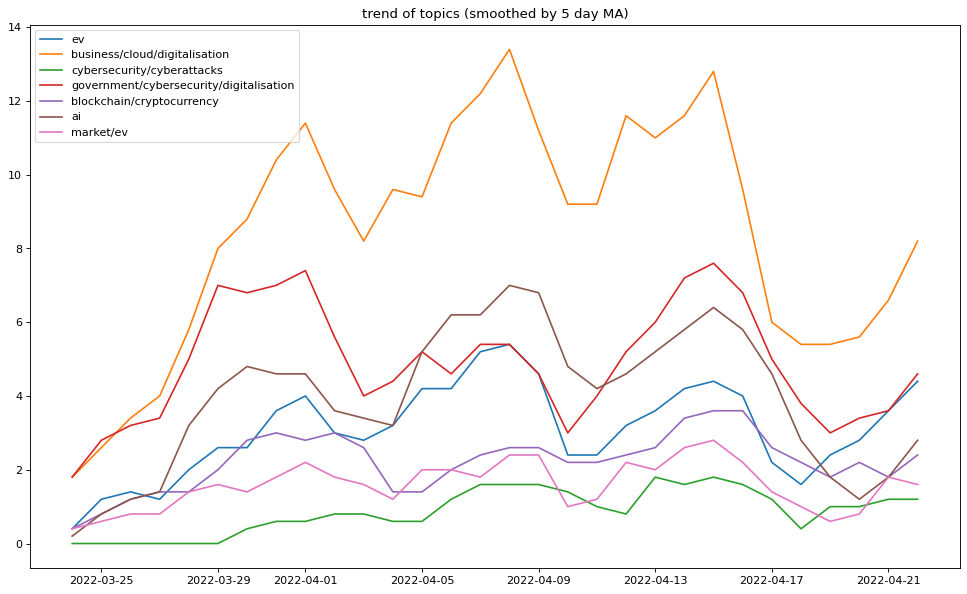

In [2834]:
create_line_chart(df,topic_dict2)
    

In [2538]:
lda_model.get_document_topics(corpus_test[:1], minimum_probability = 0.001)

In [2908]:
#calculating model perplexity

perplexity = lda_model.log_perplexity(corpus2)

#printing model perplexity

print(perplexity)


-7.87618383611376


In [2904]:
#calculating model perplexity

perplexity = lda_model2.log_perplexity(corpus_test)

#printing model perplexity

print(perplexity)

-9.157780746512918


In [1685]:
test.text.loc[7]

'Tesla will finally start selling the Cybertruck next year, Elon Musk has announced at the opening party for the company\'s Giga Texas factory. During his presentation on stage, Musk showed off the production Cybertruck vehicle, which still looks like the previous versions, except its doors no longer have handles. The car will be able to tell that you\'re there and will know that it\'s supposed to open the doors. He also apologized for the delay on releasing the Cybertruck that was first announced back in 2019. Tesla\'s original (and highly optimistic) target release date was 2021, but it delayed the vehicle\'s launch to 2022, and now to 2023.\n\nThe automaker will manufacture the Cybertruck at its Texas Gigafactory, which it expects to become the "highest volume" car factory in America. Musk touched upon its other planned Gigactories around the world, as well, and how manufacturing vehicles near where they\'re going to be shipped is much more environmentally friendly. This year is all

In [2564]:
corpus2,_ , data_lemmatized2, id2word2 =  prepare_data(df['clean_text'])

In [2768]:
lda_model2 = build_lda(corpus2, id2word2,7,100,10)

In [2769]:
# Print the Keyword in the 10 topics
print(lda_model2.print_topics())
doc_lda2 = lda_model2[corpus2]

[(0, '0.021*"ev" + 0.017*"car" + 0.015*"battery" + 0.015*"vehicle" + 0.010*"production" + 0.010*"electric" + 0.010*"carbon" + 0.009*"energy" + 0.008*"model" + 0.006*"emission"'), (1, '0.019*"datum" + 0.013*"business" + 0.012*"service" + 0.012*"cloud" + 0.011*"market" + 0.010*"customer" + 0.009*"solution" + 0.008*"platform" + 0.008*"digital" + 0.007*"security"'), (2, '0.023*"security" + 0.016*"vulnerability" + 0.011*"threat" + 0.008*"quest" + 0.007*"code" + 0.007*"memory" + 0.007*"vr" + 0.006*"hardware" + 0.006*"attack" + 0.005*"actor"'), (3, '0.013*"government" + 0.009*"group" + 0.009*"firm" + 0.008*"country" + 0.007*"security" + 0.006*"cybersecurity" + 0.006*"company" + 0.006*"attack" + 0.005*"remittance" + 0.005*"policy"'), (4, '0.048*"blockchain" + 0.034*"game" + 0.012*"player" + 0.012*"transaction" + 0.012*"card" + 0.011*"crypto" + 0.011*"cryptocurrency" + 0.011*"nft" + 0.008*"digital" + 0.008*"fund"'), (5, '0.026*"ai" + 0.012*"system" + 0.010*"human" + 0.009*"computer" + 0.008*"er

In [2819]:
topic_dict2={0:'ev',1:'business/cloud/digitalisation',2:'cybersecurity/cyberattacks',3: 'government/cybersecurity/digitalisation',4:'blockchain/cryptocurrency',5:'ai',6:'market/ev'}

In [2912]:
len(corpus2)

480

In [2791]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model2, corpus2, id2word2, mds='mmds')
vis

/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/ruinah/Documents/ISYE6740/project/api/myenv/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's docum

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.048278 -0.023612       1        1  36.162057
5     -0.084643 -0.263173       2        1  20.805067
3     -0.263890 -0.073365       3        1  15.839553
0     -0.197725  0.234725       4        1  10.191153
4      0.217362 -0.217183       5        1   7.733204
6      0.279350  0.067882       6        1   6.633233
2      0.097823  0.274726       7        1   2.635733, topic_info=            Term        Freq       Total Category  logprob  loglift
1675  blockchain  434.000000  434.000000  Default  30.0000  30.0000
488     security  483.000000  483.000000  Default  29.0000  29.0000
1             ai  662.000000  662.000000  Default  28.0000  28.0000
190         game  324.000000  324.000000  Default  27.0000  27.0000
1202          ev  256.000000  256.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1587      remote   13.157585   59.213576   Topic7  -5.4394   2.1319
1485      update   10.853773   28.171673   Topic7  -5.6319   2.6822
2726      minute   10.627001   55.567483   Topic7  -5.6530   1.9818
359       camera   10.084923   42.628815   Topic7  -5.7054   2.1945
103       device   10.049534  276.118899   Topic7  -5.7089   0.3227

[454 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5787      7  0.956358         0x
7323      7  0.855618        1ff
340       1  0.109417   accuracy
340       2  0.889013   accuracy
2189      3  0.548058      actor
...     ...       ...        ...
1012      1  0.977806     worker
7878      7  0.898360  workspace
4183      5  0.991187      world
3699      7  0.906543       wyze
9745      5  0.954114     zprize

[870 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 1, 5, 7, 3])

### Conclusion for LDA
- Hard to determine which topic belongs to which cluster as the topics we are looking for do not fit neatly into the clusters eg. cybersecurity appears in so many clusters, so does digital government
- Have to find another approach to classify the articles into the respective topics

In [2702]:
labels2 = [lda_model2.get_document_topics(doc,minimum_probability=0.1) for doc in corpus2]

In [2820]:
topic_dict2

{0: 'ev',
 1: 'business/cloud/digitalisation',
 2: 'cybersecurity/cyberattacks',
 3: 'government/cybersecurity/digitalisation',
 4: 'blockchain/cryptocurrency',
 5: 'ai',
 6: 'market/ev'}

In [2766]:
df.labels.apply(lambda x: assign_label(x, topic_dict2))

0                       [cloud/digitalisation, ai, None]
2                                               [ev, ai]
3      [cloud/digitalisation, blockchain/cryptocurren...
5                                                   [ai]
6      [cloud/digitalisation, government/cybersecurit...
                             ...                        
516    [cloud/digitalisation, government/cybersecurit...
517    [cloud/digitalisation, government/cybersecurit...
518    [cloud/digitalisation, government/cybersecurit...
519    [government/cybersecurity/digitalisation, bloc...
520    [cloud/digitalisation, government/cybersecurit...
Name: labels, Length: 480, dtype: object

In [2899]:
df= get_labels(df,lda_model2, corpus2, topic_dict2, 'category_y',0.15)

the no of correct labels is: 0.925


In [2816]:
df

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct,category
0,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",283,"[ai, ai]","[(1, 0.6576761), (5, 0.32353237)]","[cloud/digitalisation, ai]",1,"[ai, ai]"
1,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,the verge,"[artificial, intelligence, tool, reads, chest,...","oxipit statement, x, ce mark, x rays, programs...",211,[ai],"[(0, 0.23495781), (5, 0.61647916)]","[ev, ai]",1,[ai]
2,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[football, clubs, australia, artificial, intel...","gobubble, safe, technology, unlimited access, ...",122,"[ai, ai]","[(3, 0.26613078), (4, 0.5635273)]","[government/cybersecurity/digitalisation, bloc...",0,"[ai, ai]"
3,Does AI get more hype than it deserves?,https://img-cdn.tnwcdn.com/image/neural?filter...,28/03/2022,How different would we think about artificial ...,https://thenextweb.com/news/ai-get-more-hype-t...,How different would we think about artificial ...,the next web,"[different, think, artificial, intelligence, a...","thought experiment, complex, artificial, artif...",503,[ai],"[(5, 0.74470705)]",[ai],1,[ai]
4,China uses AI software to improve its surveill...,https://www.reuters.com/resizer/xUweqB0rmCsdEw...,08/04/2022,Dozens of Chinese firms have built software th...,https://www.reuters.com/world/china/china-uses...,"BEIJING, April 8 (Reuters) - Dozens of Chinese...",reuters,"[beijing, dozens, chinese, firms, built, softw...","software, security, tenders, huawei, comment, ...",726,[ai],"[(3, 0.6900261)]",[government/cybersecurity/digitalisation],0,[ai]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,Investigating the drivers of remittance fees,https://voxeu.org/sites/default/files/cover_im...,18/04/2022,Remittances continue to be an importance sourc...,https://voxeu.org/article/investigating-driver...,Investigating the drivers of remittance fees\n...,voxeu.org,"[investigating, drivers, remittance, fees, tho...","higher, market, remittance fees, corridors, fe...",768,[digitalisation],"[(3, 0.79296905)]",[government/cybersecurity/digitalisation],1,[digitalisation]
476,2C2P and Ant Group Enter Strategic Partnership...,https://mms.businesswire.com/media/20220418005...,18/04/2022,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",https://www.businesswire.com/news/home/2022041...,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",business wire,"[singapore, business, wire, 2c2p, global, paym...","ant, business, partnership, payments solutions...",423,[digitalisation],"[(1, 0.90210223)]",[cloud/digitalisation],1,[digitalisation]
477,Real estate expert advises firms on building t...,https://cdn.punchng.com/wp-content/uploads/201...,18/04/2022,An expert in real estate development and busin...,https://punchng.com/real-estate-expert-advises...,An expert in real estate development and busin...,the punch,"[expert, real, estate, development, business, ...","others, society, whole part, real, businesses,...",234,[digitalisation],"[(1, 0.6889139)]",[cloud/digitalisation],1,[digitalisation]
478,GobiMin reports its 2021 Financial Results,https://s.yimg.com/uu/api/res/1.2/cPoGCIMZcIVJ...,21/04/2022,(Expressed in United States dol

In [2797]:
df.loc[287]

title               First malware targeting AWS Lambda serverless ...
imgurl              https://venturebeat.com/wp-content/uploads/202...
date                                                       06/04/2022
blurp               Cado Security researchers say they've discover...
url                 https://venturebeat.com/2022/04/06/first-malwa...
text                We are excited to bring Transform 2022 back in...
source                                                    venturebeat
clean_text          [excited, bring, transform, virtually, join, a...
keywords            software, threat actors, serverless, researche...
word_count                                                        425
category_y                                                    [cloud]
labels                              [(1, 0.49396777), (2, 0.3395668)]
predicted_labels    [cloud/digitalisation, cybersecurity/cyberatta...
correct                                                             1
category            

In [2222]:
df['labels'] =labels2

In [2778]:
np.log(lda_model2.bound(corpus_test))

/var/folders/h5/q_hpffn12_589xblfw6_4j1m0000gn/T/ipykernel_24615/3617179733.py:1: RuntimeWarning: invalid value encountered in log
  np.log(lda_model2.bound(corpus_test))


nan

In [2756]:
coherence_score = []
per =[]
for i in range(2,15):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus2,
                                               id2word=id2word2,
                                               num_topics=i, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=False)
    cm = CoherenceModel(model=lda_model2, corpus=corpus2, texts =data_lemmatized2, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus_test)
    per.append(perplexity)
    coherence = cm.get_coherence()
    print('Num topics:', i,'\nCoherence Score: ', coherence)
    coherence_score.append(coherence)


Num topics: 2 
Coherence Score:  0.30535560871589346
Num topics: 3 
Coherence Score:  0.37783174123486213
Num topics: 4 
Coherence Score:  0.404896462139814
Num topics: 5 
Coherence Score:  0.45753125191343863
Num topics: 6 
Coherence Score:  0.4766087815253517
Num topics: 7 
Coherence Score:  0.5364860931004116
Num topics: 8 
Coherence Score:  0.48111086955649246
Num topics: 9 
Coherence Score:  0.4760490416260877
Num topics: 10 
Coherence Score:  0.5131319320020754
Num topics: 11 
Coherence Score:  0.4379962926527282
Num topics: 12 
Coherence Score:  0.5007496792769509
Num topics: 13 
Coherence Score:  0.45113139356559895
Num topics: 14 
Coherence Score:  0.47344904471686167


Text(0, 0.5, 'log perplexity')

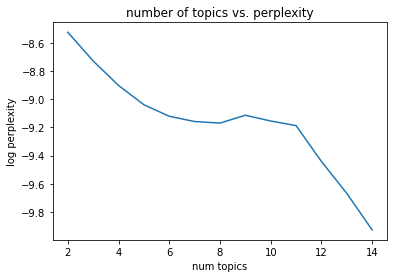

In [2757]:
plt.plot(list(range(2,15)),per )

plt.title("number of topics vs. perplexity")
plt.xlabel('num topics')
plt.ylabel('log perplexity')

Text(0, 0.5, 'c_v coherence score')

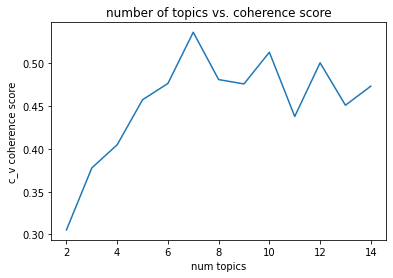

In [2758]:
plt.plot(list(range(2,15)),coherence_score )

plt.title("number of topics vs. coherence score")
plt.xlabel('num topics')
plt.ylabel('c_v coherence score')

In [2754]:
#calculating model perplexity

perplexity = lda_model2.log_perplexity(corpus2)



#printing model perplexity

print(perplexity)

-7.818394365886212


In [2753]:
#calculating model perplexity

perplexity = lda_model2.log_perplexity(corpus_test)



#printing model perplexity

print(perplexity)

-9.157780639927084


In [ ]:
Hey Govan, the negatuve sign is just because it's a logarithm of a number. Perplexity is basically the generative probability of that sample (or chunk of sample), it should be as high as possible. Since log(x) is monotonically increasing with x, gensim perplexity should also be high for a good model. So in your case, "-6" is better than "-7" for example

In [ ]:
#as this is the log of perplexity a smaller value -7.8 is better than the -9.15 which makes sense as the training set should perform better than the test set

In [2711]:
topic_dict2

{0: 'ev',
 6: 'market/ev',
 3: 'government/cybersecurity/digitalisation',
 5: 'ai',
 4: 'blockchain/cryptocurrency',
 2: 'cybersecurity/cyberattacks',
 1: 'cloud/digitalisation'}

In [2632]:
lda_model2.print_topics()

[(0,
  '0.021*"ev" + 0.017*"car" + 0.015*"battery" + 0.015*"vehicle" + 0.010*"production" + 0.010*"electric" + 0.010*"carbon" + 0.009*"energy" + 0.008*"model" + 0.006*"emission"'),
 (1,
  '0.019*"datum" + 0.013*"business" + 0.012*"service" + 0.012*"cloud" + 0.011*"market" + 0.010*"customer" + 0.009*"solution" + 0.008*"platform" + 0.008*"digital" + 0.007*"security"'),
 (2,
  '0.023*"security" + 0.016*"vulnerability" + 0.011*"threat" + 0.008*"quest" + 0.007*"code" + 0.007*"memory" + 0.007*"vr" + 0.006*"hardware" + 0.006*"attack" + 0.005*"actor"'),
 (3,
  '0.013*"government" + 0.009*"group" + 0.009*"firm" + 0.008*"country" + 0.007*"security" + 0.006*"cybersecurity" + 0.006*"company" + 0.006*"attack" + 0.005*"remittance" + 0.005*"policy"'),
 (4,
  '0.048*"blockchain" + 0.034*"game" + 0.012*"player" + 0.012*"transaction" + 0.012*"card" + 0.011*"crypto" + 0.011*"cryptocurrency" + 0.011*"nft" + 0.008*"digital" + 0.008*"fund"'),
 (5,
  '0.026*"ai" + 0.012*"system" + 0.010*"human" + 0.009*"comp

In [2694]:
test_set_cleaned.text.loc[53]

'The Chevy Corvette is getting an update. Having been some of the most beautiful, and many of the ugliest, sports cars ever made, the \'Vette has always fascinated me. GM has announced that both a plug-in hybrid and an all-electronic model are in the works.\n\nElectric sports cars are not a novelty, and the Corvette will likely be very fast, if it can turn is a whole other question.\n\nNPR:\n\n"We will have an electrified Corvette next year, so it\'s coming very quick," General Motors President Mark Reuss told CNBC on Monday. An "electrified" Corvette will be available first, with a fully electric Corvette to follow, he said. Reuss didn\'t go into further details, such as a precise timeline or whether "electrified" means it will be a plug-in hybrid. The traditional Corvette with internal combustion engine will remain available for sale, Reuss acknowledged. Although GM\'s experience with electric vehicles goes back decades — its late-1990s EV1 was the first mass-produced electric vehicl

In [2713]:
check_category(test_set_cleaned['category_y'][70],test_set_cleaned['predicted_labels'][70])

1

In [2804]:
len(corpus)

318

In [2805]:
lda_model2.get_document_topics(corpus2[287],minimum_probability=0.2)

[(0, 0.9240114)]

In [2806]:
df.loc[287]

title               First malware targeting AWS Lambda serverless ...
imgurl              https://venturebeat.com/wp-content/uploads/202...
date                                                       06/04/2022
blurp               Cado Security researchers say they've discover...
url                 https://venturebeat.com/2022/04/06/first-malwa...
text                We are excited to bring Transform 2022 back in...
source                                                    venturebeat
clean_text          [excited, bring, transform, virtually, join, a...
keywords            software, threat actors, serverless, researche...
word_count                                                        425
category_y                                                    [cloud]
labels                              [(1, 0.49396777), (2, 0.3395668)]
predicted_labels    [cloud/digitalisation, cybersecurity/cyberatta...
correct                                                             1
category            

In [2726]:
test_set_cleaned['category'] = test_set_cleaned['category_y'].apply(lambda x: x[0].lower())

In [2890]:
get_labels(test_set_cleaned,lda_model2, corpus_test, topic_dict2, 'category_y',0.2).loc[27]

the no of correct labels is: 0.8309859154929577


title               A Simple Way to Help Make Sure Your Passwords ...
imgurl              https://assets.entrepreneur.com/content/3x2/20...
date                                                       27/04/2022
blurp               Your online security is a big deal. That's why...
url                       https://www.entrepreneur.com/article/425506
text                Disclosure: Our goal is to feature products an...
source                                                   entrepreneur
clean_text          [disclosure, goal, feature, products, services...
keywords            security, manager, vaults, information, enpass...
word_count                                                        167
category_y                                            [cybersecurity]
labels                                              [(1, 0.44955894)]
predicted_labels                      [business/cloud/digitalisation]
correct                                                             0
category            

In [2882]:
get_labels(test_set_cleaned,lda_model2, corpus_test, topic_dict2, 'category_y')

the no of correct labels is: 0.5915492957746479


,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct,category
0,Open source technology in logistics sector,https://ubuntu.com/wp-content/uploads/dc7e/sha...,27/04/2022,Why use open source technology in industries? ...,https://ubuntu.com/blog/open-source-technology...,Why use open source technology in industries?\...,ubuntu.com,"[open, source, industries, word, open, source,...","digital transformation, logistics sector, mult...",740,[digitalisation],"[(1, 0.8615009)]",[business/cloud/digitalisation],1,[digitalisation]
1,Five new partners of PKF hospitality group,https://www.hospitalitynet.org/HN-icon.jpg,27/04/2022,PKF hospitality group announces five new partn...,https://www.hospitalitynet.org/news/4110164.html,PKF hospitality group announces five new partn...,hospitality net,"[pkf, hospitality, group, announces, partners,...","tourism leisure, research, leisure, tourism, h...",216,[digitalisation],"[(1, 0.48433092), (3, 0.35629824)]","[business/cloud/digitalisation, government/cyb...",1,[digitalisation]
2,A hostile parliament to Macron could paralyse ...,https://www.euractiv.com/wp-content/uploads/si...,27/04/2022,"In today’s edition of the Capitals, find out m...",https://www.euractiv.com/section/politics/news...,The Capitals brings you the latest news from a...,euractiv,"[capitals, brings, latest, news, across, europ...","read, european, president, european commission...",1152,[digitalisation],"[(3, 0.62794673)]",[government/cybersecurity/digitalisation],1,[digitalisation]
3,Bink appoints executives from HSBC and Visa as...,https://www.finextra.com/finextra-images/top_p...,27/04/2022,Loyalty app Bink has appointed two executives ...,https://www.finextra.com/newsarticle/40143/bin...,Loyalty app Bink has appointed two executives ...,finextra,"[loyalty, app, bink, appointed, executives, hs...","business, lloyds, bink, loyalty, hsbc, asia pa...",192,[digitalisation],"[(1, 0.4931565), (3, 0.2575468)]","[business/cloud/digitalisation, government/cyb...",1,[digitalisation]
4,Africa: Tough Reforms Needed to Support Africa...,https://cdn08.allafrica.com/static/images/stru...,27/04/2022,[Ghanaian Times] Tough reforms anchored on eff...,https://allafrica.com/stories/202204270399.html,Tough reforms anchored on effective revenue mo...,allafrica - top africa news,"[tough, reforms, anchored, effective, revenue,...","business, pandemic, sector, economic, financia...",323,[digitalisation],"[(1, 0.23654366), (3, 0.58161324)]","[business/cloud/digitalisation, government/cyb...",1,[digitalisation]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,Should You Buy Tesla Ahead of Its Stock Split?,https://g.foolcdn.com/editorial/images/673559/...,27/04/2022,The EV leader is gearing up for another stock ...,https://www.fool.com/investing/2022/04/27/shou...,A regulatory filing made by Tesla (TSLA 2.94%)...,motley fool,"[regulatory, filing, made, tesla, tsla, end, r...","stock, investors, market, margin, impressive g...",307,[EV],"[(0, 0.23145455), (1, 0.25351855), (6, 0.41743...","[ev, business/cloud/digitalisation, market/ev]",0,[ev]
67,Lucid signs deal with Saudi Arabia for up to 1...,https://o.aolcdn.com/images/dims3/GLOB/legacy_...,27/04/2022,"Filed under:\n Green,Electric,Lucid\n Continue...",https://www.autoblog.com/2022/04/27/lucid-1000...,Electric carmaker Lucid Group on Tuesday said ...,autoblog,"[electric, carmaker, lucid, group, tuesday, si...","vehicles, production, agreement, saudi arabia,...",139,[EV],"[(0, 0.48511875), (3, 0.24720636)]","[ev, government/cybersecurity/digitalisation]",0,[ev]
68,Batteries are getting cheap. So why aren’t ele...,https://grist.org/wp-content/uploads/2022/04/t...,27/04/2022,"In 2015, the average price paid for an EV was ...",http://grist.org/article/batteries-are-getting...,If the world has learned one thing from the ad...,grist,"[learned, thing, adoption, wind, solar, green,...","powered cars, electric car, price parity, car,..

In [2901]:
test_set_cleaned2= get_labels(test_set_cleaned,lda_model2, corpus_test, topic_dict2, 'category_y',0.15)
# labels = [lda_model2.get_document_topics(doc,minimum_probability=0.2) for doc in corpus_test ]
# test_set_cleaned['labels'] =labels
# test_set_cleaned['predicted_labels'] = test_set_cleaned.labels.apply(lambda x: assign_label(x, topic_dict2))
# test_set_cleaned['correct'] = test_set_cleaned.apply(lambda x: check_category(x['predicted_labels'], x['category']), axis=1)
# print("the no of correct labels is:" , test_set_cleaned['correct'].sum() / len(test_set_cleaned['correct']))

the no of correct labels is: 0.9014084507042254


In [2875]:
test_set_cleaned.loc[27]

title               A Simple Way to Help Make Sure Your Passwords ...
imgurl              https://assets.entrepreneur.com/content/3x2/20...
date                                                       27/04/2022
blurp               Your online security is a big deal. That's why...
url                       https://www.entrepreneur.com/article/425506
text                Disclosure: Our goal is to feature products an...
source                                                   entrepreneur
clean_text          [disclosure, goal, feature, products, services...
keywords            security, manager, vaults, information, enpass...
word_count                                                        167
category_y                                            [cybersecurity]
labels                                              [(1, 0.44957268)]
predicted_labels                      [business/cloud/digitalisation]
correct                                                             0
category            

In [ ]:
corpus_test, _,data_lemmatized_test =  prepare_data_test(test_set_cleaned['clean_text'],id2word2)

In [2695]:
test_set_cleaned['labels'] = [lda_model2.get_document_topics(doc,minimum_probability =0.1) for doc in corpus_test]

test_set_cleaned['predicted_labels'] = test_set_cleaned.labels.apply(lambda x: assign_label(x, topic_dict2))
test_set_cleaned['correct'] = test_set_cleaned.apply(lambda x: check_category(x['predicted_labels'], x['category_y']), axis=1)


In [2696]:
test_set_cleaned['correct'].sum()/ len(test_set_cleaned['correct'])

0.6901408450704225

In [2698]:
test_set_cleaned[test_set_cleaned['correct']==0]

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct,category
20,First fully open-source Kubernetes security pl...,https://venturebeat.com/wp-content/uploads/202...,27/04/2022,Security provider ARMO releases first fully op...,https://venturebeat.com/2022/04/27/first-fully...,We are excited to bring Transform 2022 back in...,venturebeat,"[excited, bring, transform, virtually, join, a...","kubernetes, number, security, tools, source, e...",332,[ai],"[(1, 0.8178242)]",[cloud/digitalisation],0,ai
25,Salesforce deepens Slack integration with new ...,https://venturebeat.com/wp-content/uploads/202...,27/04/2022,Salesforce has launched a new toolkit to help ...,https://venturebeat.com/2022/04/27/salesforce-...,We are excited to bring Transform 2022 back in...,venturebeat,"[excited, bring, transform, virtually, join, a...","business, software, platform slack, slack sale...",411,[ai],"[(1, 0.68959755), (6, 0.19902109)]","[cloud/digitalisation, market/evs]",0,ai
31,Polestar 2 EV Gets Longer Real-World Electric ...,https://www.carscoops.com/wp-content/uploads/2...,27/04/2022,Use of traceable materials reduces carbon foot...,https://www.carscoops.com/2022/04/polestar-2-e...,Polestar has treated its 2 EV to a range of up...,carscoops,"[polestar, treated, ev, range, updates, necess...","co2e reduction, vegan leather, sustainability,...",216,[blockchain],"[(0, 0.54579926), (1, 0.12129334), (5, 0.16981...","[ev, cloud/digitalisation, ai]",0,blockchain
34,How to Map Out Your Digital Transformation,https://hbr.org/resources/images/article_asset...,27/04/2022,If digital transformation is supposed to be me...,https://hbr.org/2022/04/how-to-map-out-your-di...,If digital transformation is supposed to be me...,harvard business review,"[digital, transformation, supposed, meaningful...","business, digital transformation, technology, ...",1175,[blockchain],"[(0, 0.12002133), (1, 0.6699477), (5, 0.132089...","[ev, cloud/digitalisation, ai]",0,blockchain
53,GM announces the EV Corvette,https://i0.wp.com/boingboing.net/wp-content/up...,27/04/2022,The Chevy Corvette is getting an update. Havin...,https://boingboing.net/2022/04/27/gm-announces...,The Chevy Corvette is getting an update. Havin...,boing boing,"[chevy, corvette, getting, update, beautiful, ...","hybrid, whole question, plug, sports cars, che...",101,[EV],"[(0, 0.671026), (4, 0.10476058)]","[ev, blockchain/cryptocurrency]",0,EV
54,Column: Automakers go back to the future to se...,https://www.reuters.com/pf/resources/images/re...,27/04/2022,Column: Automakers go back to the future to se...,https://www.reuters.com/markets/commodities/au...,An Aries lithium iron phosphate battery pack i...,reuters,"[aries, lithium, iron, phosphate, battery, pac...","ev, unlimited access, trust principles, self s...",574,[EV],"[(0, 0.5375214), (1, 0.1698822), (3, 0.12589975)]","[ev, cloud/digitalisation, government/cybersec...",0,EV
55,Iron man Elon Musk places his Tesla battery be...,https://www.reuters.com/resizer/w_fn2kkoGj_2-q...,27/04/2022,As Tesla's profits and prices grabbed headline...,https://www.reuters.com/business/autos-transpo...,Aries lithium iron phosphate cells are seen at...,reuters,"[aries, lithium, iron, phosphate, cells, seen,...","ev, cells, ncm cells, united states, battery, ...",661,[EV],"[(0, 0.46548116), (1, 0.15917979), (3, 0.16414...","[ev, cloud/digitalisation, government/cybersec...",0,EV
56,Tesla's stock plunged $126 billion the day aft...,https://i.insider.com/6268b662fad9260019aaf547...,27/04/2022,Investors fear that Musk will sell some of his...,https://markets.businessinsider.com/news/stock...,"On Tuesday, Tesla lost $126 billion in value a...",business insider,"[tuesday, tesla, lost, billion, value, ceo, el...","stock, musk, takeover, value, stake, tesla, bi...",235,[EV],"[(0, 0.3150758), (3, 0.2902647), (6, 0.2859084)]","[ev, government/cybersecurity/digitalisation, ...",0,EV
57,GM electrifies executives' pay - Reuters,

In [2629]:
test_set_cleaned['labels'][63]

[(1, 0.31257537), (3, 0.33144796), (5, 0.15582971)]

In [ ]:
{}

In [2697]:
test_set_cleaned[test_set_cleaned['category'] == 'EV']

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct,category
53,GM announces the EV Corvette,https://i0.wp.com/boingboing.net/wp-content/up...,27/04/2022,The Chevy Corvette is getting an update. Havin...,https://boingboing.net/2022/04/27/gm-announces...,The Chevy Corvette is getting an update. Havin...,boing boing,"[chevy, corvette, getting, update, beautiful, ...","hybrid, whole question, plug, sports cars, che...",101,[EV],"[(0, 0.671026), (4, 0.10476058)]","[ev, blockchain/cryptocurrency]",0,EV
54,Column: Automakers go back to the future to se...,https://www.reuters.com/pf/resources/images/re...,27/04/2022,Column: Automakers go back to the future to se...,https://www.reuters.com/markets/commodities/au...,An Aries lithium iron phosphate battery pack i...,reuters,"[aries, lithium, iron, phosphate, battery, pac...","ev, unlimited access, trust principles, self s...",574,[EV],"[(0, 0.5375214), (1, 0.1698822), (3, 0.12589975)]","[ev, cloud/digitalisation, government/cybersec...",0,EV
55,Iron man Elon Musk places his Tesla battery be...,https://www.reuters.com/resizer/w_fn2kkoGj_2-q...,27/04/2022,As Tesla's profits and prices grabbed headline...,https://www.reuters.com/business/autos-transpo...,Aries lithium iron phosphate cells are seen at...,reuters,"[aries, lithium, iron, phosphate, cells, seen,...","ev, cells, ncm cells, united states, battery, ...",661,[EV],"[(0, 0.46548116), (1, 0.15917979), (3, 0.16414...","[ev, cloud/digitalisation, government/cybersec...",0,EV
56,Tesla's stock plunged $126 billion the day aft...,https://i.insider.com/6268b662fad9260019aaf547...,27/04/2022,Investors fear that Musk will sell some of his...,https://markets.businessinsider.com/news/stock...,"On Tuesday, Tesla lost $126 billion in value a...",business insider,"[tuesday, tesla, lost, billion, value, ceo, el...","stock, musk, takeover, value, stake, tesla, bi...",235,[EV],"[(0, 0.3150758), (3, 0.2902647), (6, 0.2859084)]","[ev, government/cybersecurity/digitalisation, ...",0,EV
57,GM electrifies executives' pay - Reuters,https://www.reuters.com/resizer/UBDsfKfyJBmuOz...,27/04/2022,"General Motors <a href=""https://www.reuters.co...",https://www.reuters.com/breakingviews/gm-elect...,U.S. President Joe Biden drives a Hummer EV as...,reuters,"[president, joe, biden, drives, hummer, ev, to...","read, unlimited access, trust principles, gene...",202,[EV],"[(0, 0.357548), (1, 0.15022601), (3, 0.2771641...","[ev, cloud/digitalisation, government/cybersec...",0,EV
58,Factbox: Factbox: Electric car battery showdow...,https://www.reuters.com/resizer/mTJjQLMiPmJ27P...,27/04/2022,Several companies plan to open production faci...,https://www.reuters.com/business/autos-transpo...,Two Aries lithium iron phosphate battery packs...,reuters,"[aries, lithium, iron, phosphate, battery, pac...","highlights, cells, products, status private, b...",478,[EV],"[(0, 0.42840078), (1, 0.19672537), (3, 0.12953...","[ev, cloud/digitalisation, government/cybersec...",0,EV
59,Indonesia's foreign direct investment surges 3...,https://www.reuters.com/pf/resources/images/re...,27/04/2022,Foreign direct investment (FDI) in Indonesia s...,https://www.reuters.com/world/asia-pacific/ind...,Summary\n\nSummary Companies Q1 FDI amounts to...,reuters,"[summary, summary, companies, q1, fdi, amounts...","investors, unlimited access, rupiah, sources, ...",197,[EV],"[(0, 0.14245492), (1, 0.20794374), (3, 0.42766...","[ev, cloud/digitalisation, government/cybersec...",0,EV
60,Mini Cooper maker’s new ebikes are merging hig...,https://img-cdn.tnwcdn.com/image/shift?filter_...,27/04/2022,I always thought Mini Coopers were pretty cool...,https://thenextweb.com/news/cooper-ebikes-brin...,Cate Lawrence is an Australian tech journo liv...,the next web,"[cate, lawrence, australian, tech, journo, liv...","classic, vtol smart, 7e, vehicles vtol, credit...",408,[EV],"[(0, 0.6243491), (1, 0.19351201)]","[ev, cloud/digitalisation]",0,EV
61,The

In [2611]:
test_set_cleaned['text'][60]

"Cate Lawrence is an Australian tech journo living in Berlin. She focuses on all things mobility: ebikes, autonomous vehicles, VTOL, smart ci (show all) Cate Lawrence is an Australian tech journo living in Berlin. She focuses on all things mobility: ebikes, autonomous vehicles, VTOL, smart cities, and the future of alternative energy sources like electric batteries, solar, and hydrogen.\n\nI always thought Mini Coopers were pretty cool, so I was pleased this week to learn that the Cooper Car Company, the original designer of the Mini Cooper, rolled out not one, but four electric bikes. They sit under the dedicated two-wheel division, Cooper Bikes.\n\nThe Cooper Bikes Company was founded in 2009 aiming to build innovative bikes for the urban environment. And they look a treat!\n\nCooper has rolled out four bikes based on a central configuration. Credit: Cooper Bikes\n\nThese ebikes don’t resemble the somewhat space-age futuristic chunky offerings that some other companies are rolling ou

In [2794]:
id2word2

In [2792]:
lda_model2[corpus2[287]]

[(0, 0.9240194), (1, 0.014025799), (5, 0.053520277)]

In [2801]:
lda_model2.get_document_topics(corpus2[287])


[(0, 0.92402303), (1, 0.014021446), (5, 0.053521007)]

In [2810]:
df

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct,category
0,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",283,"[ai, ai]","[(1, 0.65767574), (5, 0.3235328)]","[cloud/digitalisation, ai]",1,"[ai, ai]"
2,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,the verge,"[artificial, intelligence, tool, reads, chest,...","oxipit statement, x, ce mark, x rays, programs...",211,[ai],"[(0, 0.23495916), (5, 0.61648285)]","[ev, ai]",1,[ai]
3,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[football, clubs, australia, artificial, intel...","gobubble, safe, technology, unlimited access, ...",122,"[ai, ai]","[(3, 0.2661305), (4, 0.56352574)]","[government/cybersecurity/digitalisation, bloc...",0,"[ai, ai]"
5,Does AI get more hype than it deserves?,https://img-cdn.tnwcdn.com/image/neural?filter...,28/03/2022,How different would we think about artificial ...,https://thenextweb.com/news/ai-get-more-hype-t...,How different would we think about artificial ...,the next web,"[different, think, artificial, intelligence, a...","thought experiment, complex, artificial, artif...",503,[ai],"[(5, 0.74470615)]",[ai],1,[ai]
6,China uses AI software to improve its surveill...,https://www.reuters.com/resizer/xUweqB0rmCsdEw...,08/04/2022,Dozens of Chinese firms have built software th...,https://www.reuters.com/world/china/china-uses...,"BEIJING, April 8 (Reuters) - Dozens of Chinese...",reuters,"[beijing, dozens, chinese, firms, built, softw...","software, security, tenders, huawei, comment, ...",726,[ai],"[(3, 0.6900316)]",[government/cybersecurity/digitalisation],0,[ai]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,Investigating the drivers of remittance fees,https://voxeu.org/sites/default/files/cover_im...,18/04/2022,Remittances continue to be an importance sourc...,https://voxeu.org/article/investigating-driver...,Investigating the drivers of remittance fees\n...,voxeu.org,"[investigating, drivers, remittance, fees, tho...","higher, market, remittance fees, corridors, fe...",768,[digitalisation],"[(3, 0.79296887)]",[government/cybersecurity/digitalisation],1,[digitalisation]
517,2C2P and Ant Group Enter Strategic Partnership...,https://mms.businesswire.com/media/20220418005...,18/04/2022,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",https://www.businesswire.com/news/home/2022041...,"SINGAPORE--(BUSINESS WIRE)--2C2P, a global pay...",business wire,"[singapore, business, wire, 2c2p, global, paym...","ant, business, partnership, payments solutions...",423,[digitalisation],"[(1, 0.9020845)]",[cloud/digitalisation],1,[digitalisation]
518,Real estate expert advises firms on building t...,https://cdn.punchng.com/wp-content/uploads/201...,18/04/2022,An expert in real estate development and busin...,https://punchng.com/real-estate-expert-advises...,An expert in real estate development and busin...,the punch,"[expert, real, estate, development, business, ...","others, society, whole part, real, businesses,...",234,[digitalisation],"[(1, 0.68891406)]",[cloud/digitalisation],1,[digitalisation]
519,GobiMin reports its 2021 Financial Results,https://s.yimg.com/uu/api/res/1.2/cPoGCIMZcIVJ...,21/04/2022,(Expressed in United States dol

In [2813]:
df.loc[479]

title               Playable Worlds raises over $25M for cloud-bas...
imgurl              https://venturebeat.com/wp-content/uploads/202...
date                                                       20/04/2022
blurp               Playable Worlds announced today that it has se...
url                 https://venturebeat.com/2022/04/20/playable-wo...
text                GamesBeat Summit 2022 returns with its largest...
source                                                    venturebeat
clean_text          [gamesbeat, summit, returns, largest, event, l...
keywords            technology, goldberg, playable, entrepreneur d...
word_count                                                        731
category_y                                                    [cloud]
labels                               [(1, 0.2591808), (4, 0.6270513)]
predicted_labels    [cloud/digitalisation, blockchain/cryptocurrency]
correct                                                             1
category            

In [2903]:
#Loop over all the documents to group the probability of each topic
topic_dict_stored = {i: [] for i in range(7)} 
for docID in range(len(corpus2)):
    topic_vector = lda_model2[corpus2[docID]]
    for topicID, prob in topic_vector:
        topic_dict_stored[topicID].append((docID, prob))
#Then, you can sort the dictionary to find the top 20 documents:
topic_dict_docs ={i: [] for i in range(7)} 
for topicID, probs in topic_dict_stored.items():
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top_3 = [dp[0] for dp in doc_probs[:3]] 
    topic_dict_docs[topicID] =docs_top_3
for i in topic_dict_docs.keys():
    print(i, "topic:" , topic_dict2[i])
    print("-------------------------")
    for docs in topic_dict_docs[i]:
        print(docs)
        print("Assigned topic:" , topic_dict2[i])
        print("Assigned topic (multi):" , df.predicted_labels.loc[docs])
        print("Original Topic:", df.loc[docs].category_y)
        print("Correct?:", df.loc[docs].correct)
        print("text:",df.loc[docs].text)
        print("----------------------")

0 topic: ev
-------------------------
287
Assigned topic: ev
Assigned topic (multi): ['ev']
Original Topic: ['EV']
Correct?: 1
text: If you thought it wouldn't be long before Kia turned the Concept EV9 into a production model, you guessed correctly. The automaker has revealed that a road-ready version of the electric SUV will be available in Europe in 2023. There was no mention of launches in North America or other regions, but it's an SUV — it may just be a matter of time before you see the EV9 cruising American and Canadian streets.

Kia didn't say what would change in the transition from concept to production. However, we'd expect the badge to cut many of the more exotic features, including the yoke, giant wheels, retractable roof rails and lounge-like seating modes. We wouldn't be surprised if Kia kept the 27-inch display and even the hood-mounted solar panel, though.

The production EV9 might also preserve the claimed specs. The concept promised up to 300 miles of range and 350kW 

In [2843]:
topic_dict2

{0: 'ev',
 1: 'business/cloud/digitalisation',
 2: 'cybersecurity/cyberattacks',
 3: 'government/cybersecurity/digitalisation',
 4: 'blockchain/cryptocurrency',
 5: 'ai',
 6: 'market/ev'}

In [ ]:
test

In [2895]:
lda_model2.get_document_topics(corpus_test[27],minimum_probability =0.1)

[(1, 0.44953728), (2, 0.1684596), (3, 0.122121066), (5, 0.16937418)]

In [2900]:
lda_model2[corpus_test[20]],test_set_cleaned2.loc[20].labels,test_set_cleaned2.loc[20].text

([(1, 0.8178251),
  (2, 0.099079855),
  (3, 0.011480023),
  (5, 0.056640927),
  (6, 0.013896913)],
 [(1, 0.8178275)],
 'We are excited to bring Transform 2022 back in-person July 19 and virtually July 20 - 28. Join AI and data leaders for insightful talks and exciting networking opportunities. Register today!\n\nToday, security company ARMO announced that it has raised $30 million series A funding for the first fully open-source Kubernetes security platform, Kubescape.\n\nThe solution can scan Kubernetes deployments for misconfigurations and vulnerabilities across the entire software development lifecycle, calculate risk scores instantly, highlight risk trends, and automatically suggest changes to configuration files.\n\nIn other words, Kubescape aims to offer enterprises a single pane of glass for securing Kubernetes environments that security teams can use to scan for misconfigurations and vulnerabilities, rather than relying on a disparate patchwork of isolated open-source security 

In [2856]:
lda_model2[corpus_test[9]]

[(0, 0.2785628),
 (1, 0.30054843),
 (2, 0.19989452),
 (3, 0.042440046),
 (5, 0.15401043),
 (6, 0.017263226)]

In [2857]:
 sorted(topic_dict_stored[2], key = lambda x: x[1], reverse = True)

[(35, 0.30351523),
 (9, 0.19989467),
 (27, 0.16845673),
 (13, 0.10471893),
 (20, 0.09907944),
 (57, 0.068323575),
 (21, 0.047242645),
 (24, 0.046332933),
 (53, 0.04599089),
 (10, 0.040671084),
 (64, 0.036041822),
 (43, 0.029505298),
 (48, 0.027265647),
 (17, 0.02711373),
 (14, 0.025961485),
 (31, 0.024202839),
 (15, 0.02279694),
 (37, 0.01956423),
 (45, 0.018000271),
 (55, 0.017685859),
 (19, 0.016309699),
 (18, 0.016309654),
 (30, 0.015909651),
 (23, 0.015599606),
 (69, 0.015279437),
 (3, 0.013219815),
 (7, 0.011830663),
 (46, 0.011821402),
 (25, 0.0116320485),
 (61, 0.011048457),
 (36, 0.010699461)]

In [2902]:
#Loop over all the documents to group the probability of each topic
topic_dict_stored = {i: [] for i in range(7)} 
for docID in range(len(corpus_test)):
    topic_vector = lda_model2[corpus_test[docID]]
    for topicID, prob in topic_vector:
        topic_dict_stored[topicID].append((docID, prob))
#Then, you can sort the dictionary to find the top 20 documents:
topic_dict_docs ={i: [] for i in range(7)} 
for topicID, probs in topic_dict_stored.items():
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top_5 = [dp[0] for dp in doc_probs[:5]] 
    topic_dict_docs[topicID] =docs_top_5
for i in topic_dict_docs.keys():
    print(i, "topic:" , topic_dict2[i])
    print("-------------------------")
    for docs in topic_dict_docs[i]:
        print(docs)
        print("Assigned topic:" , topic_dict2[i])
        print("Assigned topic (multi):" , test_set_cleaned.predicted_labels.loc[docs])
        print("Original Topic:", test_set_cleaned.loc[docs].category_y)
        print("Correct?:",test_set_cleaned.loc[docs].correct)
        print("text:",test_set_cleaned.loc[docs].text)
        print("----------------------")

0 topic: ev
-------------------------
53
Assigned topic: ev
Assigned topic (multi): ['ev']
Original Topic: ['EV']
Correct?: 1
text: The Chevy Corvette is getting an update. Having been some of the most beautiful, and many of the ugliest, sports cars ever made, the 'Vette has always fascinated me. GM has announced that both a plug-in hybrid and an all-electronic model are in the works.

Electric sports cars are not a novelty, and the Corvette will likely be very fast, if it can turn is a whole other question.

NPR:

"We will have an electrified Corvette next year, so it's coming very quick," General Motors President Mark Reuss told CNBC on Monday. An "electrified" Corvette will be available first, with a fully electric Corvette to follow, he said. Reuss didn't go into further details, such as a precise timeline or whether "electrified" means it will be a plug-in hybrid. The traditional Corvette with internal combustion engine will remain available for sale, Reuss acknowledged. Although 

In [2210]:
df['predicted_labels'] = df.labels.apply(lambda x: assign_label(x, topic_dict))
df['predicted_labels2'] = df.labels.apply(lambda x: return_max(x, topic_dict))

In [2212]:
df['correct'] = df.apply(lambda x: check_category(x['predicted_labels'], x['category_y']), axis=1)
df['correct'].sum() / len(df['correct'])

0.48057259713701433

In [2065]:
test['correct'] = test.apply(lambda x: check_category(x['predicted_labels'], x['y']), axis=1)
test['correct'].sum() / len(test['correct'])

0.8805031446540881

In [2068]:
test['correct'] = test.apply(lambda x: check_category2(x['predicted_labels2'], x['y']), axis=1)
test['correct'].sum() / len(test['correct'])

0.559748427672956

In [2580]:
topic_dict2

{0: 'ev',
 6: 'market/evs',
 3: 'government/cybersecurity/digitalisation',
 5: 'ai',
 4: 'blockchain/cryptocurrency',
 2: 'cybersecurity/cyberattacks',
 1: 'cloud/digitalisation'}

In [2067]:
lda_model[corpus[3]]

[(1, 0.38191333), (2, 0.39811975), (4, 0.022142427), (5, 0.1967744)]

In [1629]:
lda_model.get_document_topics(corpus[3],0)

[(0, 0.069160834),
 (1, 0.7312146),
 (2, 0.0006161343),
 (3, 0.00023549226),
 (4, 0.008450032),
 (5, 0.19032289)]

In [ ]:
test.text

In [1624]:
test.predicted_labels2.loc[3],test.predicted_labels.loc[3]

('market/digitalisation',
 ['market/digitalisation', 'data/cloud/digitalisation'])

In [1630]:
test.text.loc[3]

"Ioanna is a writer at SHIFT. She likes the transition from old to modern, and she's all about shifting perspectives. Ioanna is a writer at SHIFT. She likes the transition from old to modern, and she's all about shifting perspectives.\n\nHondatoday announced some pretty bold electrification plans to achieve carbon neutrality by \u200b\u200b2050.\n\nThe Japanese automaker will invest $40 billion (¥5 trillion yen) in its EV segment, including a new lineup, battery production, and software development.\n\n30 new EV models by 2030\n\nYep, you read that right. 30 new EVs by 2030.\n\nThis is huge for Honda, especially as it’s currently only offering one electric vehicle — the Honda e — which itself is limited to the European market.\n\nThe company is planning to launch EVs that are tailored for each market, and is aiming for a production volume of more than two million units per year.\n\nStarting now and continuing through the second half of the decade, Honda will introduce the following veh

In [1259]:
test

,y,tokens,text,labels,predicted_labels,predicted_labels2,correct
0,EV,"[machines, seen, battery, tray, assembly, line...",Machines are seen on a battery tray assembly l...,"[(1, 0.13559191), (2, 0.19294752), (3, 0.26974...","[data/machine_learning/ai/digitalisation, data...",None,1
1,EV,"[delhi, india, planning, rules, batteries, sco...","NEW DELHI, April 22 (Reuters) - India is plann...","[(0, 0.11402196), (2, 0.2065639), (3, 0.138871...","[blockchain/cybersecurity, data/cloud/digitali...",None,1
2,EV,"[announcing, first, electric, vehicle, last, c...",After announcing the company's first electric ...,"[(1, 0.428921), (4, 0.5120325)]","[data/machine_learning/ai/digitalisation, None]",None,1
3,EV,"[ioanna, writer, shift, likes, transition, old...",Ioanna is a writer at SHIFT. She likes the tra...,"[(0, 0.1805655), (1, 0.21056029), (2, 0.209232...","[blockchain/cybersecurity, data/machine_learni...",None,1
4,EV,"[bmw, developed, first, fully, electric, serie...",BMW has developed the first fully electric 3 s...,"[(1, 0.2972469), (3, 0.17279837), (4, 0.4737619)]","[data/machine_learning/ai/digitalisation, mark...",None,1
...,...,...,...,...,...,...,...
303,"[digitalisation, cloud]","[excited, bring, transform, virtually, join, a...",We are excited to bring Transform 2022 back in...,"[(2, 0.9985148)]",[data/cloud/digitalisation],data/cloud/digitalisation,1
304,"[digitalisation, cloud]","[big, data, analytics, cloud, computing, iot, ...","Big Data Analytics, Cloud Computing, and IoT (...","[(1, 0.4302074), (2, 0.5692768)]","[data/machine_learning/ai/digitalisation, data...",data/cloud/digitalisation,1
305,"[digitalisation, cloud]","[although, ukraine, russia, war, worsened, glo...",Although the Ukraine-Russia war has worsened t...,"[(2, 0.9987338)]",[data/cloud/digitalisation],data/cloud/digitalisation,1
306,"[ai, digitalisation]","[bank, england, asking, lenders, insurers, pay...",The Bank of England is asking lenders and insu...,"[(3, 0.90551925)]",[market/digitalisation/government],market/digitalisation/government,1


In [1618]:
test['correct'] = test.apply(lambda x: check_category2(x['predicted_labels2'], x['y']), axis=1)
test['correct'].sum() / len(test['correct'])

0.5691823899371069

In [1599]:
test[test.y == 'digitalisation']

,y,tokens,text,labels,predicted_labels,predicted_labels2,correct
235,digitalisation,"[norwind, offshore, signs, flexible, connectiv...",Norwind Offshore signs flexible connectivity a...,"[(1, 0.5147466), (5, 0.46961403)]","[market/digitalisation, data/cloud/digitalisat...",market/digitalisation,1
236,digitalisation,"[batmobile, batman, movie, looks, stunning, ra...","Yes, the Batmobile in The Batman movie looks s...","[(0, 0.595768), (4, 0.3312611)]","[EV, data/machine_learning/ai]",EV,0
237,digitalisation,"[private, security, guard, stands, exit, gate,...",A private security guard stands at the exit ga...,"[(1, 0.7571148), (5, 0.13356563)]","[market/digitalisation, data/cloud/digitalisat...",market/digitalisation,1
238,digitalisation,"[windows, pointed, last, week, still, rules, m...",Windows 10 – as we pointed out last week – sti...,"[(4, 0.20590521), (5, 0.75535053)]","[data/machine_learning/ai, data/cloud/digitali...",data/cloud/digitalisation,1
239,digitalisation,"[products, recommended, engadget, selected, ed...",All products recommended by Engadget are selec...,"[(0, 0.21396014), (1, 0.2419022), (5, 0.5413126)]","[EV, market/digitalisation, data/cloud/digital...",data/cloud/digitalisation,1
240,digitalisation,"[transport, group, go, ahead, pledged, resume,...",Transport group Go-Ahead has pledged to resume...,"[(1, 0.98848283)]",[market/digitalisation],market/digitalisation,1
241,digitalisation,"[intel, study, finds, businesses, eager, cyber...",An Intel study finds that businesses are eager...,"[(4, 0.1461202), (5, 0.85126156)]","[data/machine_learning/ai, data/cloud/digitali...",data/cloud/digitalisation,1
242,digitalisation,"[george, town, cope, increase, minimum, wage, ...",GEORGE TOWN: To cope with the increase in the ...,"[(1, 0.656311), (5, 0.340913)]","[market/digitalisation, data/cloud/digitalisat...",market/digitalisation,1
243,digitalisation,"[tim, logo, seen, headquarters, rome, italy, y...",The Tim logo is seen at its headquarters in Ro...,"[(1, 0.75826925), (2, 0.112575), (5, 0.1280029)]","[market/digitalisation, blockchain/cybersecuri...",market/digitalisation,1
244,digitalisation,"[chairs, spokespersons, working, groups, table...",The Chairs and spokespersons of nine Working G...,"[(1, 0.45758888), (3, 0.40334472), (5, 0.10200...","[market/digitalisation, government/cybersecuri...",market/digitalisation,1


In [1480]:
df['correct'] = df.apply(lambda x: check_category2(x['predicted_labels2'], x['category_y']), axis=1)

In [1481]:
df['correct'].sum() / len(df['correct'])

0.48057259713701433

In [1284]:
test[test.correct == 0]


,y,tokens,text,labels,predicted_labels,predicted_labels2,correct
6,EV,"[washington, dc, cnn, building, cheap, car, pr...","Washington, DC (CNN) Building a cheap car that...","[(0, 0.14903912), (1, 0.27411193), (2, 0.13923...","[blockchain/cybersecurity, data/machine_learni...",data/machine_learning/ai/digitalisation,0
7,EV,"[tesla, finally, start, selling, cybertruck, n...",Tesla will finally start selling the Cybertruc...,"[(1, 0.34333497), (3, 0.5731915)]","[data/machine_learning/ai/digitalisation, mark...",market/digitalisation/government,0
10,EV,"[chevrolet, bolt, plug, electric, vehicle, dis...",A 2019 Chevrolet Bolt plug-in electric vehicle...,"[(3, 0.84279954)]",[market/digitalisation/government],market/digitalisation/government,0
11,EV,"[google, latest, phone, maker, join, apple, sa...",Google is the latest phone maker to join Apple...,"[(1, 0.3851472), (2, 0.12000539), (3, 0.4522361)]","[data/machine_learning/ai/digitalisation, data...",market/digitalisation/government,0
13,EV,"[ev, car, good, cat, ora, brand, great, wall, ...","EV car Good Cat by Ora, a brand by Great Wall ...","[(2, 0.18223403), (3, 0.61810106)]","[data/cloud/digitalisation, market/digitalisat...",market/digitalisation/government,0
...,...,...,...,...,...,...,...
279,digitalisation,"[india, ready, electric, vehicles, maruti, suz...",India not ready for electric vehicles yet: Mar...,"[(0, 0.10132075), (1, 0.2966822), (2, 0.165526...","[blockchain/cybersecurity, data/machine_learni...",EV,0
280,digitalisation,"[summary, summary, companies, combines, larges...",Summary\n\nSummary Companies Combines two of t...,"[(0, 0.7503572), (2, 0.15668125)]","[blockchain/cybersecurity, data/cloud/digitali...",blockchain/cybersecurity,0
281,digitalisation,"[general, view, video, unit, motherboard, russ...",A general view of the video unit motherboard o...,"[(0, 0.35448042), (1, 0.2942822), (2, 0.237701...","[blockchain/cybersecurity, data/machine_learni...",blockchain/cybersecurity,0
288,"[ai, cloud]","[eastern, europe, based, research, institute, ...",A new Eastern Europe-based research institute ...,"[(0, 0.10314763), (1, 0.27703145), (2, 0.15144...","[blockchain/cybersecurity, data/machine_learni...",market/digitalisation/government,0


In [963]:
test.text.loc[57]

'The Top Benefits of a Data-Driven B2B Demand Gen Strategy\n\nB2B marketers have said that better leads, customer experience, and return on investment (ROI) were among the top benefits of effective data-driven strategy, while 54 percent said that quality data enables them to make more effective spending decisions, according to newly-released survey data of interest to digital marketers. MarketingProfs\n\nPrepare for the future with Google Analytics 4\n\nGoogle will sunset its longstanding existing analytics incarnation in July 2023, and has laid out a plan encouraging users of the present version to switch to the new version, which adds greater privacy law compliance, while also removing access to analytics data from the current version, the search giant recently announced. Google\n\nWanted in B2B ecommerce: smooth supply chains and skilled workers\n\n43 percent of B2B sellers have said that a top challenge in 2022 will be achieving supply chain improvement, while some 39 percent noted

In [492]:
df.head()

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y
0,"What Is Machine Learning, and How Can It Help ...",https://assets.entrepreneur.com/content/3x2/20...,27/03/2022,Artificial intelligence helps create content m...,https://www.entrepreneur.com/article/420562,Opinions expressed by Entrepreneur contributor...,entrepreneur,"[opinions, expressed, entrepreneur, contributo...","analytics, marketers, predictive analytics, fu...",3894,[ai]
1,First autonomous X-ray-analyzing AI is cleared...,https://cdn.vox-cdn.com/thumbor/Na1FxfmSilyVlK...,05/04/2022,An X-ray-analyzing tool called ChestLink has a...,https://www.theverge.com/2022/4/5/23011291/ima...,An artificial intelligence tool that reads che...,the verge,"[artificial, intelligence, tool, reads, chest,...","oxipit statement, x, ce mark, x rays, programs...",2596,[ai]
2,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[reuters, football, clubs, australia, artifici...","gobubble, safe, technology, unlimited access, ...",1508,[ai]
3,Does AI get more hype than it deserves?,https://img-cdn.tnwcdn.com/image/neural?filter...,28/03/2022,How different would we think about artificial ...,https://thenextweb.com/news/ai-get-more-hype-t...,How different would we think about artificial ...,the next web,"[different, think, artificial, intelligence, a...","thought experiment, complex, artificial, artif...",6355,[ai]
4,China uses AI software to improve its surveill...,https://www.reuters.com/resizer/xUweqB0rmCsdEw...,08/04/2022,Dozens of Chinese firms have built software th...,https://www.reuters.com/world/china/china-uses...,"BEIJING, April 8 (Reuters) - Dozens of Chinese...",reuters,"[beijing, reuters, dozens, chinese, firms, bui...","software, security, tenders, huawei, comment, ...",8763,[ai]


In [383]:
lda_model2.get_document_topics(corpus[333],minimum_probability=0.3)

[(3, 0.4360034), (5, 0.46036726)]

In [380]:
topic_dict

{3: 'EV',
 5: 'government/cybersecurity/digitalisation',
 0: 'data/cloud/digitalisation',
 4: 'market',
 1: 'blockchain',
 2: 'machine_learning/ai'}

In [1602]:
lda_model2[corpus2[2]]

([(0, 0.8011889), (3, 0.19337249)],
 [(7, [3]),
  (44, [0, 3]),
  (56, [0, 3]),
  (95, [3, 0]),
  (125, [0, 3]),
  (148, [3]),
  (158, [0, 3]),
  (172, [0, 3]),
  (173, [0, 3]),
  (174, [3, 0]),
  (175, [0]),
  (176, [0, 3]),
  (177, [3, 0]),
  (178, [0]),
  (179, [0]),
  (180, [0, 3]),
  (181, [0, 3]),
  (182, [0]),
  (183, [0, 3]),
  (184, [0, 3]),
  (185, [0, 3]),
  (186, [0]),
  (187, [0]),
  (188, [0]),
  (189, [0, 3]),
  (190, [0]),
  (191, [0]),
  (192, [0, 3]),
  (193, [3]),
  (194, [3, 0]),
  (195, [0]),
  (196, [0, 3]),
  (197, [0]),
  (198, [3, 0]),
  (199, [0, 3]),
  (200, [0]),
  (201, [0]),
  (202, [0, 3]),
  (203, [0, 3]),
  (204, [0, 3]),
  (205, [0, 3]),
  (206, [0, 3]),
  (207, [0, 3]),
  (208, [0, 3]),
  (209, [0]),
  (210, [0, 3]),
  (211, [3, 0]),
  (212, [0]),
  (213, [3, 0]),
  (214, [0]),
  (215, [0, 3]),
  (216, [0])],
 [(7, [(3, 0.99886656)]),
  (44, [(0, 1.4919147), (3, 0.5076513)]),
  (56, [(0, 0.70297176), (3, 0.29685527)]),
  (95, [(0, 0.23461214), (3, 0.7

In [382]:
#Create a dictionary, with topic ID as the key, and the value is a list of tuples 
#(docID, probability of this particular topic for the doc) 


#Loop over all the documents to group the probability of each topic

for docID in range(len(corpus)):
    topic_vector = lda_model[corpus[docID]]
    for topicID, prob in topic_vector:
        topic_dict[topicID].append((docID, prob))

#Then, you can sort the dictionary to find the top 20 documents:

for topicID, probs in topic_dict.items():
    doc_probs = sorted(probs, key = lambda x: x[1], reverse = True)
    docs_top_20 = [dp[0] for dp in doc_probs[:20]]  

['board',
 'logo',
 'renault',
 'display',
 'car',
 'showroom',
 'saint',
 'petersburg',
 'russia',
 'reuters',
 'reuters',
 'photographer',
 'file_photo',
 'paris',
 'reuters',
 'renault',
 'rena',
 'pa',
 'chief_executive',
 'luca',
 'de',
 'meo',
 'tuesday',
 'automaker',
 'plans',
 'create',
 'separate',
 'division',
 'electric',
 'ev',
 'assets',
 'eventually',
 'lead',
 'separate',
 'listing',
 'mean',
 'separate',
 'listing',
 'conditional',
 'precisely',
 'reviewing',
 'de',
 'meo',
 'news',
 'conference',
 'plan',
 'separate',
 'combustion',
 'engines',
 'activity',
 'interest',
 'nissan',
 'long_term',
 'investors',
 'added',
 'register_free',
 'unlimited_access',
 'reuters_com',
 'register',
 'de',
 'meo',
 'wants',
 'press',
 'ahead',
 'plans',
 'create',
 'separate',
 'divisions',
 'electric',
 'ev',
 'combustion',
 'engine',
 'vehicles',
 'despite',
 'potentially',
 'costly',
 'uncertainty',
 'interests',
 'russia',
 'sources',
 'reuters',
 'last',
 'week',
 'read',
 'pla

In [210]:
assign_label(lda_model2.get_document_topics(corpus[333],minimum_probability=0.01),topic_dict)

['government/cybersecurity/digitalisation',
 'data/cloud/digitalisation',
 'market/digitalisation',
 'EV']

In [240]:
df.category_y.unique()

TypeError: unhashable type: 'list'

In [163]:
# Create Corpus
data_words_bigrams[333]



['ev',
 'car',
 'good',
 'cat',
 'ora',
 'brand',
 'great',
 'wall',
 'motors',
 'displayed',
 'bangkok',
 'international',
 'motor',
 'show',
 'bangkok',
 'thailand',
 'reuters',
 'athit',
 'perawongmetha',
 'bangkok',
 'reuters',
 'thailand',
 'expanded',
 'incentives',
 'boost',
 'electric_vehicles',
 'evs',
 'investment',
 'promotion',
 'agency',
 'thursday',
 'country',
 'looks',
 'preserve',
 'status',
 'major',
 'southeast',
 'asian',
 'auto',
 'production',
 'hub',
 'smaller',
 'charging',
 'stations',
 'eligible',
 'tax',
 'benefits',
 'extra',
 'incentive',
 'corporate',
 'income',
 'tax',
 'exemption',
 'available',
 'investments',
 'charging',
 'stations',
 'least',
 'chargers',
 'duangjai',
 'asawachintachit',
 'head',
 'board',
 'investment',
 'boi',
 'news',
 'conference',
 'condition',
 'barring',
 'investors',
 'receiving',
 'additional',
 'benefits',
 'agencies',
 'requirement',
 'iso',
 'certification',
 'removed',
 'register_free',
 'unlimited_access',
 'reuters_com

In [376]:
# Term Document Frequency
lda_model2.get_document_topics(id2word.doc2bow(data_words_bigrams[333]))


[(1, 0.02779544), (2, 0.07391922), (3, 0.43600345), (5, 0.460371)]

In [194]:
topic_dict

{5: 'EV',
 1: 'government/cybersecurity/digitalisation',
 2: 'data/cloud/digitalisation',
 3: 'market/digitalisation',
 4: 'blockchain',
 0: 'machine_learning/ai/data'}

In [237]:
df['text'].loc[333]

'EV car Good Cat by Ora, a brand by Great Wall Motors, is displayed at the Bangkok International Motor show in Bangkok, Thailand, March 22, 2022. REUTERS/Athit Perawongmetha\n\nBANGKOK, April 7 (Reuters) - Thailand has expanded incentives to boost the use of electric vehicles (EVs), the investment promotion agency said on Thursday, as the country looks to preserve its status as a major Southeast Asian auto production hub.\n\nSmaller charging stations will now be eligible for three-year tax benefits, an extra incentive on top of a five-year corporate income tax exemption available to investments in charging stations with at least 40 chargers, Duangjai Asawachintachit, head of the Board of Investment (BOI), told a news conference.\n\nA condition barring investors from receiving additional benefits from other agencies, and a requirement for ISO certification have also been removed, she said.\n\nRegister now for FREE unlimited access to Reuters.com Register\n\nThe revised measures are "to 

In [153]:
df[df['correct']==0]

,title,imgurl,date,blurp,url,text,source,clean_text,keywords,word_count,category_y,labels,predicted_labels,correct
2,Australian leagues sign deal to combat online ...,https://www.reuters.com/resizer/Ml-ukx_nTJIuh9...,03/04/2022,Football clubs in Australia will use artificia...,https://www.reuters.com/lifestyle/sports/austr...,April 3 (Reuters) - Football clubs in Australi...,reuters,"[reuters, football, clubs, australia, artifici...","gobubble, safe, technology, unlimited access, ...",1508,"[ai, machine learning]","[(2, 0.14100401), (3, 0.19241339), (5, 0.63473...","[data/cloud/digitalisation, market/digitalisat...",0
13,Le Monde launches digital English language edi...,https://i.guim.co.uk/img/media/6fe6f7cfb464a3f...,07/04/2022,The French newspaper’s new initiative is part ...,https://amp.theguardian.com/media/2022/apr/07/...,Show caption Le Monde’s digital English editio...,the guardian,"[show, caption, le, monde, digital, english, e...","language, paper, le, french, share, subscriber...",1372,[ai],"[(3, 0.18533504), (5, 0.7735031)]","[market/digitalisation, EV]",0
33,India watchdog recommends 36% cut in base pric...,https://www.reuters.com/pf/resources/images/re...,11/04/2022,India's telecoms watchdog on Monday recommende...,https://www.reuters.com/world/india/india-watc...,People stand in front of a board depicting 5G ...,reuters,"[stand, front, board, depicting, 5g, network, ...","5g, telecom, unlimited access, indian, registe...",1715,[ai],"[(1, 0.4566166), (2, 0.19900711), (3, 0.3103444)]","[government/cybersecurity/digitalisation, data...",0
63,"UnitedHealth, Change Healthcare extend closure...",https://www.reuters.com/resizer/bzh2NMnUOkYy8j...,05/04/2022,"UnitedHealth Group Inc <a href=""https://www.re...",https://www.reuters.com/business/healthcare-ph...,The corporate logo of the UnitedHealth Group a...,reuters,"[corporate, logo, unitedhealth, group, appears...","change healthcare, software, change, unitedhea...",1710,[ai],"[(1, 0.16453977), (3, 0.6710772), (5, 0.117601...","[government/cybersecurity/digitalisation, mark...",0
64,U.S. private payrolls increase solidly in Marc...,https://www.reuters.com/resizer/HcRSVSSd98mG7I...,30/03/2022,U.S. private employers maintained a strong pac...,https://www.reuters.com/world/us/us-private-pa...,A restaurant advertising jobs looks to attract...,reuters,"[restaurant, advertising, jobs, looks, attract...","third, market, jobs, labor, quarter, workers, ...",6257,[ai],"[(1, 0.11957745), (3, 0.8793897)]","[government/cybersecurity/digitalisation, mark...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,After the IPO: IonQ takes on highly charged qu...,https://venturebeat.com/wp-content/uploads/202...,13/04/2022,"By some measures, IonQ was late to the quantum...",https://venturebeat.com/2022/04/13/after-the-i...,We are excited to bring Transform 2022 back in...,venturebeat,"[excited, bring, transform, virtually, join, a...","spac path, public, quantum race, technology, c...",5739,[cloud],"[(0, 0.40811333), (3, 0.10326008), (5, 0.40688...","[machine_learning/ai/data, market/digitalisati...",0
296,"India's Infosys profit rises 12%, forecasts hi...",https://www.reuters.com/resizer/VnMTLHH_cc0ZrU...,13/04/2022,"Infosys Ltd <a href=""https://www.reuters.com/c...",https://www.reuters.com/world/india/indias-inf...,An employee walks past a signage board in the ...,reuters,"[employee, walks, past, signage, board, infosy...","business, infosys, unlimited access, bengaluru...",1882,[cloud],"[(1, 0.13228638), (3, 0.86436236)]","[government/cybersecurity/digitalisation, mark...",0
313,IBM’s new Qiskit primitives make it easier to ...,https://img-cdn.tnwcdn.com/image/neural?filter...,12/04/2022,"The quantum computing race is far from over, b...",https://thenextweb.com/news/ibms-new-qiskit-pr...,"The quantum computing race is far from over, b...",the next web,"[quantum, computing, race, far, clear, ibm, ea...","qiskit, problems, quantum computers, qiskit ru...",5594,[cloud],"[(

In [ ]:
def return_max(label):
    """
    takes a list of tuple(s)
    and returns the tuple with the highest second element
    """
    max_val= max(label, key=lambda x:x[1])[1]
    return [e[0] for e in label if e[1] == max_val][0]


In [ ]:
labels_single = [return_max(x)for x in labels]

In [ ]:
df['labels'] = labels
df['single_label']= labels_single

In [ ]:
df.single_label.value_counts()

In [ ]:
#cleaning function to get list of cleaned sentences
def cleaning(t):
    t = re.sub("[^0-9a-zA-Z\\s-]"," ", t)
    t = re.sub('[0-9]{2,4}', ' ', t)
    sentence = re.sub(r'\s+', ' ', t)
    sentence = unicodedata.normalize("NFKD", sentence) 
    sentence = ' '.join([w.lower() for w in sentence.split() if len(w) > 1 and w not in stop_words])
    return sentence.split()

def cleaning2(t):
    t = re.sub("[^0-9a-zA-Z\\s]"," ", t)
    t = re.sub('[0-9]{2,4}', ' ', t)
    sentence = re.sub(r'\s+', ' ', t)
    sentence = unicodedata.normalize("NFKD", sentence) 
    #article_text = ' '.join([w.lower() for w in article_text.split() if len(w) > 1 and w not in stop_words])
    tokens =sentence.split( )
    tags = nltk.pos_tag(tokens)
    sentence = " ".join([word.lower() for word,pos in tags if pos not in ['MD','VB','VBD','VBG','VBN','VBZ','RB','RBR','RBS','IN']])
   
    return sentence.lower()

In [ ]:
# word2vec requires sentences rather than words tokenization so tokenize to sents then clean

In [ ]:
# # df['clean_text']= df['text'].apply(lambda x: [cleaning(t) for t in sent_tokenize(x)])
# df['clean_text2']= df['text'].apply(lambda x: [cleaning(t) for t in sent_tokenize(x)])
# corpus = [item for sublist in df['clean_text2'] for item in sublist]

### Building the Word2Vec Model
-Using the lemmatized data from earlier to for word embeddings and compare words for similarity

In [ ]:
model = gensim.models.Word2Vec(
        data_lemmatized,
        vector_size=200,
        window=10,
        min_count=2,
        workers=10)

### Come up with predefined topics and use the word2vec to assign the keywords to topics
- With a list of topics (words), we can assign words to topics using their similarity score

In [ ]:
# Current topics
topics = ['cloud','analytic','ai','digitalisation','iot','blockchain','data','apps','cybersecurity']

In [ ]:
name = model.wv.most_similar('ai', topn=150)

In [ ]:
#eg of topic and words associated
name

In [ ]:
def assign_topic_score(topics, data, model,similarity_score = 0.7):
    '''
    Input:
    topic: list of topics
    data: list of words
    model: word2vec model
    Uses word2vec model to assign words to topic
    Topics with one or more words mean that the document contains the particular topic
    
    Output:
    Dictionary of dictionaries with keys being topics and values being the words associated to the topics 
    along with their corresponding similarity scores
    '''
    topic_dict ={}
    for topic in topics:
        for word in data:
            try:
                if topic not in topic_dict:
                    topic_dict[topic]={}
                else:
                    similarity = model.wv.similarity(topic, word)
                    if similarity >= similarity_score:
                        topic_dict.get(topic)[word]= similarity
        
            except:
                pass
    return topic_dict

def assign_topic(topics, data, model,similarity_score = 0.65):
    '''
     Input:
    topic: list of topics
    data: list of words
    model: word2vec model
    Uses word2vec model to assign words to topic
    Topics with one or more words mean that the document contains the particular topic
    '''
    topic_dict = assign_topic_score(topics, data, model,similarity_score)
    return [k for k,v in topic_dict.items() if len(v.keys()) >1]

def cosine_distance (model, topic,word) :
    a = model[topic]
   
    b = model [word]
    cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    
    return cos_sim

In [ ]:
df['text_lemma'] = data_lemmatized

### Using text to assign topics to each article
- Using similarity from Word2Vec embedding to determine whether word belongs to the topic
- If there is more than one word assign topic to the document

In [ ]:
df['topics']=df['text_lemma'].apply(lambda x: assign_topic(topics, x, model))
df.head()

In [ ]:
df.loc[1].topics

In [ ]:
df.loc[1].text

In [ ]:
model.wv.similarity('iot', 'internet')


In [ ]:
lemmatization([['ai','automation','sector',
  'job',
  'term',
  'relevant',
  'programme',
  'initiative',
  'covid',
  'question_remain',
  'initiative',
  'innovative_intentional',
  'available',
  'tech',
  'initial_euphoria' ]], allowed_postags=['NOUN', 'ADJ','ADP'])

In [ ]:
[data_words_bigrams[4]]

In [ ]:
assign_topic_score(topics,data_lemmatized[4], model,0.)

In [ ]:
[k for k,v in assign_topic(topics,data_lemmatized[11], model,0.6).items() if len(v.keys()) >1]

In [ ]:
model.wv.similarity('iot', 'g')

In [ ]:
def get_keyword_fr_tags(tag_df):
    keywords =set()
    for tags in tag_df['tags'].dropna().unique():
        if len(tags) > 1:
            taglist = tags.split(',')
            for word in taglist:
                keywords.add(word.strip())

        else:
            keywords.add(taglist.strip())
    return set([word.lower() for word in keywords if len(word) >1])

def remove_similar_keywords(keyword_list):
    """takes in keyword_list and removes similar words keeping only one word out of the pair(eg, vaccines, vaccine)"""

    seen =[]
#     keyword_list = keyword_list.split(', ')
    for i in keyword_list:
        for k in keyword_list:
            if (fuzz.ratio(i ,k) >=82) & (i!=k):
                seen.append(k)
#                 print(i,k)
#                 print(fuzz.ratio(i ,k))
    seen = [seen[i] for i in range(len(seen)) if i % 2 != 0]
    res = [e for e in keyword_list if e not in seen]
    return res

In [ ]:
df.text[df['text'].str.contains('gooty')]

In [ ]:
# today =datetime.datetime.strftime(datetime.date.today(),'%d%m%Y')
# file = '/Users/ruinahkoh/dev/govtech/webscrapping/scrapeinfoworld/articles/combined/combined_articles'+today+'.csv'
# df.to_csv(file, index =False)

### Gold standard for keywords
We want to make use of the tags to form a standard list of keywords used in the tech world and refer to this when extracting keywords using the Count vectorizer, so that keywords which do not appear as often could be included to the list as well. 
Current sources which provide tags: Techcrunch, CIO, Infoworld

In [ ]:
keywords = get_keyword_fr_tags(df)
keywords= keywords.union(categories)

### Allowing use input to add keywords which are not inside the gold standard list
- Certain keywords are not included in the gold standard list as they might be specific to other websites, hence user has the choice to include this manually so that the count vectorizer would pick these words up even if it does not occur as often as others

In [ ]:
### allow users to add in their own keywords
new ={'healthtech','aws','youtube','facebook','apple','data governance','data flows','5g','digital identity', 'digital id','data privacy','privacy','cyber','autonomous vehicles'}
# keywords = keywords.union(new)
# print(keywords)

In [ ]:
import json
with open('new_keywords.json', 'w') as outfile:
    json.dump(list(new), outfile)

### Using CV to extract keywords 
This would lead to many unnecessary words being added to keywords, the total count for each source/category should be able to eliminate these words.

*Processing data*:

**Remove**
- punctuation, numbers more than 2 digits by regex
- types of words belonging to adverbs, verbs, modal, preposition by postagging
- stopwords (manually added some which are hard to remove eg. days, time)

**Transform**
- to lowercase
- to count vectorizer matrix
- rank the words according to wordcount in the matrix and obtain top 10 words + top 5 bigrams + user added words in top 30 words
- bigrams limited to 5 due to noise


In [ ]:
#another method of cleaning text but this removes too many impt words
def cleaning(text):
    text = ''.join(text)
    text = text.strip()
    text = " ".join(text.split())
    text = re.sub("[^0-9a-zA-Z-]"," ", text)
    text = re.sub('[0-9]{2,4}', ' ', text)
    article_text = re.sub(r'\s+', ' ', text)
#     article_text = ' '.join([w.lower() for w in article_text.split() if w not in stopwords])
    tokens =[w.lower() for w in article_text.split() if w not in stop_words]
#     doc =nlp(article_text)
#     doc = [t.text if not t.ent_type_ else t.ent_type_ for t in doc]
#     tokens = [word for word in doc if word not in ['DATE','PERCENT', 'TIME']]
    tags = nltk.pos_tag(tokens)
    nouns = " ".join([word.lower() for word,pos in tags if pos not in ['MD','VB','VBD','VBG','VBN','VBZ','RB','RBR','RBS','IN'] and len(word) >1])
#     article_text = unicodedata.normalize("NFKD", article_text)
    return nouns

def thorough_cleaning(text):
    text = ''.join(text)
    text = text.strip()
    text = " ".join(text.split())
    text = re.sub("[^0-9a-zA-Z-]"," ", text)
    article_text = re.sub(r'\s+', ' ', text)
    article_text = ' '.join([w.lower() for w in article_text.split() if len(w) > 1 and w not in stop_words])
    article_text = unicodedata.normalize("NFKD", article_text)
    return article_text


def transform_single_text_cv(new_data_text):
    '''
    Takes in the text columns from both new data and train data and transforms data to outputs tf-idf of new data text
    
    new_data_text:  text column of new data
    train_data_text: text column of train set data
    '''
    new_data_text2 = cleaning(new_data_text)

#     new_data_text2 = thorough_cleaning(new_data_text)
#     new_data_text = new_data_text.apply(lambda x: thorough_cleaning(x))
    cv_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,stop_words=stop_words)
#     cv_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000,stop_words=stop_words)
    cv_vect.fit([new_data_text2])
    cv =  cv_vect.transform([new_data_text2])
  
    return cv, cv_vect

def transform_single_text_ngram_cv(new_data_text, ngram_range =(1,2)):
    '''
    Takes in the text columns from both new data and train data and transforms data to outputs tf-idf of new data text
    
    new_data_text:  text column of new data
    train_data_text: text column of train set data
    '''
    new_data_text2 = cleaning(new_data_text)
#     new_data_text2 = thorough_cleaning(new_data_text)
#     cv_vect_ngram = TfidfVectorizer(analyzer='word',  token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=5000,stop_words=stop_words)
    cv_vect_ngram = CountVectorizer(analyzer='word',  token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=5000,stop_words=stop_words)
    cv_vect_ngram.fit([new_data_text2])
    cv =  cv_vect_ngram.transform([new_data_text2])
    return cv, cv_vect_ngram


def sort_coo(coo_matrix):
    tuples =zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key = lambda x: (x[1],x[0]),reverse =True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results
                  
def get_keywords_from_single_text(new_data_text, method = 'cv', ngram_range=(1,2), topn=10):

    if method == 'cv':
    #transform text to tf-idf
        cv, cv_vect = transform_single_text_cv(new_data_text)
#     print(vect)
    elif method == 'ngram':
        cv, cv_vect = transform_single_text_ngram_cv(new_data_text,ngram_range = ngram_range)
    
    
    #create dictionary to translate id to name
    id2name = {idx : name for idx , name in enumerate(cv_vect.get_feature_names())}
#     print(cv)
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(cv.tocoo())  
    
    #extract only the top n; n here is 10
    keywords=extract_topn_from_vector(id2name,sorted_items,topn)
#     print(keywords)
    return keywords

#to remove duplicate/common ngrams
def clean_up(ngrams):
    '''Takes in ngram data remove duplicate unigram and bigram eg. 'digital','government' vs 'digital government'''
    seen = set()
    for ngram in ngrams:
        if ' ' in ngram:
            seen = seen.union(set(ngram.split()))
    return [ngram for ngram in ngrams if ngram not in seen]

def extract_single_text_ngram(data,ext_keywords, topn=10):
    """
    takes in a single document and extracts the keywords based on count vectorizer 
    Allows user to input list of external keywords to include in the final keyword set 
    returns a list of words
    """
    ## extracting bigrams from article (10 keywords default)
    # limit bigrams as they repeat common words
    keywords_tuple = set(list(get_keywords_from_single_text(data,'ngram',ngram_range = (2,2)))[:5]) 
    extended_tuple_words = [word for word in keywords_tuple if word in ext_keywords]
    #extract unigrams (basically ti-idf)
    keywords = list(get_keywords_from_single_text(data,'ngram',ngram_range = (1,1),topn =30))
#     print(keywords)
    extended_words = [word for word in keywords if word in ext_keywords]
   
    #adds this extra keywords to the set
    keywords = set(keywords[:topn])
#     print(keywords)
    keywords = keywords.union(keywords_tuple)
#     print(pos_tag(keywords))
    #replace the space in between words as to standardize keywords with categories
    keywords = set([word  for word,pos in pos_tag(keywords) if pos not in ['MD','VB','VBP','VBD','VBG','VBN','VBZ','RB','RBR','RBS','IN']])
#     print(keywords)
    #in case some important words are removed
    keywords = keywords.union(set(extended_words))
    keywords = keywords.union(set(extended_tuple_words))
    words = remove_similar_keywords(keywords)
#     words = clean_up(keywords)
    return list(words)

In [ ]:
df.head()

### processing the dataset
- Articles with tags can be used for keywords
- Articles without category such as techcrunch articles can obtain category from the tags?
- Use text to obtain keywords from articles
- process the keywords to ensure standardization
- group keywords and get top n keywords by date and category
- for each set of keywords? or keyword (Standalone) run an elastic search

In [ ]:
big_frame.dropna(subset =['text'], inplace =True)

In [ ]:
# techcrunch = df[df['source']=='techcrunch']
# govinsider = df[df['source']=='govinsider']
# shanghai = df[df['source']=='shanghai']
# cio = df[df['source']=='cio']
# infoworld = df[df['source']=='infoworld']

In [ ]:
def add_keywords(tags):
    keyword_dict ={}
    for tag in tags:
        if type(tag) != list:
            for word in tag.split(','):
                if word.strip() in keyword_dict.keys():
                    keyword_dict[word.strip()] += 1
                else:
                    keyword_dict[word.strip()] = 1
        else:
            for word in tag:
                if word.strip() in keyword_dict.keys():
                    keyword_dict[word.strip()] += 1
                else:
                    keyword_dict[word.strip()] = 1
                    
    return {k: v for k, v in sorted(keyword_dict.items(), key=lambda item: item[1],reverse=True)}

def extract_keywords_count(df,start_date,end_date):
    '''
    input start date and end date to get the time period to extract keywords (only for those sources without tags)
    eg. 
    start_date= '01/01/2021'
    end_date ='07/01/2021'
    '''
#     start_date = datetime.datetime.now() - datetime.timedelta(90)
    df.date= pd.to_datetime(df.date)
#     df = df[df.date >= start_date]
    start = datetime.datetime.strptime(start_date,'%d/%m/%Y')
    end = datetime.datetime.strptime(end_date,'%d/%m/%Y')
    df = df[(df.date >= start) & (df.date <= end) ]
    source_list = df.source.unique()
    total_dict={}
    keywords_dict ={}
    df['tags'][ df['tags'].isna()]=df.text.apply(lambda x: extract_single_text_ngram(x,keywords,topn=10))
    for source in source_list:
        data = df[df.source == source].reset_index()
#         if data.tags.isna().any() ==True:
#             #this step gives assigns keywords/tags to those sources without tags
#             data['tags'][ data['tags'].isna()]=data.text.apply(lambda x: extract_single_text_ngram(x,keywords,topn=10))
#             print(data['tags'])
#     data = df.reset_index()
#         print(source)
        keywords_dict[source]= add_keywords(data['tags'])
    total_dict= add_keywords(df['tags'])
    return total_dict,keywords_dict, df
        

In [ ]:
total_dict, keywords_dict,df = extract_keywords_count(df ,'07/04/2021','14/04/2021')

In [ ]:
es_list = [word for word, value in total_dict.items() if value >=2 and word in keywords]
pos_tag(es_list)

In [ ]:
es_list

In [ ]:
keywords_dict

In [ ]:
today =datetime.datetime.strftime(datetime.date.today(),'%d%m%Y')
file = '/Users/ruinahkoh/dev/govtech/webscrapping/scrapeinfoworld/articles/output/combined_articles'+today+'.csv'
df.to_csv(file, index =False)

In [ ]:
import csv
es_list = [word for word, value in total_dict.items() if value >=2 and word in keywords]
out = csv.writer(open('/Users/ruinahkoh/dev/govtech/webscrapping/scrapeinfoworld/articles/keywords/combined_articles_keywords'+today+'.csv',"w"), delimiter=',',quoting=csv.QUOTE_ALL)
out.writerow(es_list)

In [ ]:
total_dict

In [ ]:
### Testing 

In [ ]:
len(df)

In [ ]:
df.loc[80].text

In [ ]:
', '.join(extract_single_text_ngram(df.loc[100].text,keywords,topn=10))

In [ ]:
doc = nlp(df.loc[100].text)
# print([(X.text, X.label_) for X in doc.ents if X.label_ not in ['CARDINAL', 'PERCENT', 'TIME','DATE']])
# " ".join([ent.text for ent in doc if ent.label_ not in ['CARDINAL', 'PERCENT', 'TIME','DATE']])
[(X.text, X.label_) for X in doc.ents]

In [ ]:
doc.ents

In [ ]:
extract_single_text_ngram(df[df['title']=='Conduent, Hayden AI Team Up to Automate Bus Lane Enforcement'].text,keywords)

In [ ]:
govinsider['tags'] = govinsider.text.apply(lambda x: ', '.join(extract_single_text_ngram(x,keywords,topn=10)))

### Exploration of Named Entity Recognition
- A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn’t always work perfectly and might need some tuning later, depending on your use case.
- Not useful in this context as besides named entities, which the CV can pick up easily, we require concepts, topics, etc. which NER won't pick up
- But spacy could help to remove certain elements and to lemmatize words avoiding duplicates

### This section tries out corex topic modelling to get the keywords
-not as effective as cv or tf-idf

In [ ]:

# def transform_text_ngram_cv(new_data_text, ngram_range =(1,2)):
#     '''
#     Takes in the text columns from both new data and train data and transforms data to outputs tf-idf of new data text
    
#     new_data_text:  text column of new data
#     train_data_text: text column of train set data
#     '''
#     new_data_text2 = new_data_text.apply(lambda x: thorough_cleaning(x))
# #     new_data_text2 = thorough_cleaning(new_data_text)
# #     tfidf_vect_ngram = TfidfVectorizer(analyzer='word',  token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=5000,max_df = 1, stop_words=stop_words)
#     cv_vect_ngram = CountVectorizer(analyzer='word',  token_pattern=r'\w{1,}', ngram_range=ngram_range, max_features=5000,max_df = 1, stop_words=stop_words)
#     cv_vect_ngram.fit(new_data_text2)
#     cv =  cv_vect_ngram.transform(new_data_text2)
#     return cv, cv_vect_ngram

# #generate sparse matrix
# cv, vect = transform_text_ngram_cv(techcrunch['text'])
# docs = techcrunch['title']
# X =cv.tocsr()


# #fit model to the matrix
# topic_model = ct.Corex(n_hidden=10)  # Define the number of latent (hidden) topics to use.
# topic_model.fit(X, words=vect.get_feature_names(), docs=docs)



In [ ]:
# #get the topics from the model
# topics = topic_model.get_topics()

# for topic_n, topic_docs in enumerate(top_docs):
#     docs,probs = zip(*topic_docs)
#     topic_str = str(topic_n+1)+': '+', '.join(docs)
#     print(topic_str)


In [ ]:

# for topic_n,topic in enumerate(topics):
#     # w: word, mi: mutual information, s: sign
#     topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
#     # Unpack the info about the topic
#     words,mis,signs = zip(*topic)    
#     # Print topic
#     topic_str = str(topic_n+1)+': '+', '.join(words)
#     print(topic_str)top_docs = topic_model.get_top_docs()

In [ ]:
# from collections import Counter

# def cosine_similarity(word_list, vector_check):
# # word-lists to compare
#     a = vector_check
#     b = word_list

#     # count word occurrences
#     a_vals = Counter(a)
#     b_vals = Counter(b)

#     # convert to word-vectors
#     words  = list(a_vals.keys() | b_vals.keys())
#     a_vect = [a_vals.get(word, 0) for word in words]        # [0, 0, 1, 1, 2, 1]
#     b_vect = [b_vals.get(word, 0) for word in words]        # [1, 1, 1, 0, 1, 0]
#     print(b_vect)

#     # find cosine
#     len_a  = sum(av*av for av in a_vect) ** 0.5             # sqrt(7)
#     len_b  = sum(bv*bv for bv in b_vect) ** 0.5             # sqrt(4)
#     dot    = sum(av*bv for av,bv in zip(a_vect, b_vect))    # 3
#     cosine = dot / (len_a * len_b) 
#     return cosine

# govinsider['new_tags'].apply(lambda x:cosine_similarity(x, vector_check)).sort_values(ascending=False)

In [ ]:
', '.join(extract_single_text_ngram(govinsider['text'][1038],keywords,topn=10))

In [ ]:
govinsider[govinsider['url']=='https://govinsider.asia/connected-gov/gearing-up-for-the-global-5g-revolution-huawei-andy-purdy/']

In [ ]:
get_key_word(govinsider.url)

In [ ]:
from timer import Timer
def get_key_word(urls):
    key_words_dict ={}
    t = Timer()
    t.start()
    for url in urls:
        
        key_words=[]
        article = Article(url)
        article.download()

        article.html

        article.parse()
        article.nlp()
        for word in article.keywords:
            key_words.append(word)
        key_words_dict[url] = ', '.join(key_words)
    t.stop()
    return key_words_dict
    


In [ ]:
from gensim.models.phrases import Phrases,Phraser

In [ ]:
#another method of cleaning text but this removes too many impt words
def cleaning(text):
    text = ''.join(text)
    text = text.strip()
    text = " ".join(text.split())
    text = re.sub("[^0-9a-zA-Z-\.]"," ", text)
    text = re.sub('[0-9]{2,4}', ' ', text)
    article_text = re.sub(r'\s+', ' ', text)
#     article_text = ' '.join([w.lower() for w in article_text.split() if w not in stopwords])
    tokens =[w.lower() for w in article_text.split() if w not in stop_words]
#     doc =nlp(article_text)
#     doc = [t.text if not t.ent_type_ else t.ent_type_ for t in doc]
#     tokens = [word for word in doc if word not in ['DATE','PERCENT', 'TIME']]
    tags = nltk.pos_tag(tokens)
    nouns = " ".join([word.lower() for word,pos in tags if pos not in ['MD','VB','VBD','VBG','VBN','VBZ','RB','RBR','RBS','IN'] and len(word) >1])
#     article_text = unicodedata.normalize("NFKD", article_text)
    return nouns

In [ ]:
test = sent_tokenize(cleaning(df.loc[1].text))
sent_stream = [word_tokenize(sent) for sent in test]


In [ ]:
def remove_punctuation(sentence):
    
    sent = [word for word in sentence if word != '.']
    return sent

In [ ]:
sentences = [remove_punctuation(sent) for sent in sent_stream]

In [ ]:
sentences

In [ ]:
cleaning(df.loc[1].text).split(' ')

In [ ]:
phrases = Phrases(cleaning(df.loc[1].text), min_count=2, threshold=2)


In [ ]:
bigram = Phraser(phrases)
bigram[sentences[9]]

In [ ]:
# Queue implementation in Python

class Queue:

    def __init__(self):
        self.queue = []

    # Add an element
    def enqueue(self, item):
        self.queue.append(item)

    # Remove an element
    def dequeue(self):
        if len(self.queue) < 1:
            return None
        return self.queue.pop(0)

    # Display  the queue
    def display(self):
        print(self.queue)

    def size(self):
        return len(self.queue)


q = Queue()
q.enqueue(1)
q.enqueue(2)
q.enqueue(3)
q.enqueue(4)
q.enqueue(5)

print(q.display())

q.dequeue()

print("After removing an element")
q.display()
